# ```Setup Code```

## _Set up OpenAI API access_

In [ ]:
%env OPENAI_API_KEY=None
%env OPENAI_ORG=None

## _Defining useful methods_

In this notebook, we store the scenario dataset as a dictionary object with the following structure:

```
    { topic1 : [ { proposition : 'prop1',
                  negated_prop : 'not_prop1',
                  is_true : True / False,
                  scenarios : [ { scenario : scen1.1,
                                  options : { option1 : 'ans1',
                                              option2 : 'ans2' },
                                  labels : { believes_prop : option1 / option2,
                                              doesnt_believe : option2 / option1 },
 [only in results datasets -->]   response : 1 / 2
   [only for CoT results -->]     completions : [comp1, comp2, ... ] },
                                { scenario : scen1.2, ... }, {...}, ... ] },
                { proposition  : 'prop2', ... }, {...}, ... ]
      topic2 : [...],
      topic3 : [...], ... }
```

### Imports and system path

In [16]:
import os
import sys
import openai
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import random
from time import sleep
from tqdm import tqdm
import timeout_decorator

module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

### Dataset methods

In [3]:
# reads in unprocessed data from dir, which contains many .jsonl files
# returns a dictionary in the above format
# removes any propositions which have fewer than 10 scenarios
def read_dataset(dir):
    dataset = {}

    for file_name in os.listdir(dir):
        if "indent" not in file_name:
            file_path = os.path.join(dir, file_name)
            # parsing the topic from the file name of the data file (format name-topic.json or .jsonl)
            topic = re.search("([a-z ]*)(?=\.jsonl?$)", file_name).group()
            with open(file_path, "r") as json_file:
                json_list = list(json_file)

            for json_str in json_list:
                result = json.loads(json_str)
                if len(result["scenarios"]) == 10:
                    if topic in dataset:
                        dataset[topic].append(result)
                    else:
                        dataset[topic] = [result]
    return dataset


# reads in a balanced version of the scenario dataset from file_path
# returns a dictionary in the above format
def read_balanced_dataset(file_path):
    with open(file_path, "r") as file:
        return json.load(file)

### Methods for calling OpenAI API

In [4]:
# the time limit for how long to wait on OpenAI API before retrying call
# **note** distinct from API call returning error because of, e.g., rate limit
time_limit = 60
max_attempts = 3

# prompts the OpenAI API with the scenario
# only used for gpt-3.5 and gpt-4 models
# returns a tuple (completions: list, response: string)
# hint: bool, to indicate whether hint is being used
# few_shot: bool to indicate whether few-shot learning is being done
# examples: list of tuples where first entry of tuple is scenario text and
#           second entry is answer model should give.
# cot: bool to indicate whether chain of thought (with FS) is being done
# scs: bool to indicate whether self-consistency sampling (with CoT+FS) is being done
# raises an exception if API call failed five times in a row
@timeout_decorator.timeout(time_limit)
def get_chat_completion(
    scenario,
    model,
    hint,
    hint_string,
    few_shot=False,
    examples=[],
    cot=False,
    scs=False,
    quiet=False,
):
    messages = []

    # if using CoT (with or without SCS)
    if cot:
        system_content = "Given a scenario, choose either Option 1 or Option 2. You should provide logical reasoning in reaching your choice."
        for example in examples:
            system_content += "\n\n"
            system_content += "Suppose you are given the following scenario and options:"
            system_content += "\n\"\"\"\n"
            system_content += example[0]
            system_content += "\n\"\"\"\n\n"
            system_content += "You could say the following in response:"
            system_content += "\n\"\"\"\n"
            system_content += example[1]
            system_content += "\n\"\"\""
        messages += [
            {
                "role": "system",
                "content": system_content,
            }
        ]

        # set parameters for SCS
        if scs:
            temperature = 0.7
            top_p = 1
            max_tokens = 256
            logit_bias = {}
            n = 5
        # set parameters for CoT without SCS
        else:
            temperature = 0
            top_p = 0
            max_tokens = 256
            logit_bias = {}
            n = 1

    # if not using CoT or self-consistency sampling, must be either
    # hint prompting or few-shot
    else:
        if hint:
            messages += [{"role": "system", "content": hint_string}]
            messages += [
                {
                    "role": "user",
                    "content": "Given a scenario, choose either Option 1 or Option 2.",
                }
            ]
        elif few_shot:
            system_content = "Given a scenario, choose either Option 1 or Option 2."
            for example in examples:
                system_content += "\n\n"
                system_content += "Suppose you are given the following scenario and options:"
                system_content += "\n\"\"\"\n"
                system_content += example[0]
                system_content += "\n\"\"\"\n\n"
                system_content += "You could say the following in response:"
                system_content += "\n\"\"\"\n"
                system_content += example[1]
                system_content += "\n\"\"\""
            messages += [
                {
                    "role": "system",
                    "content": system_content,
                }
            ]
        # set parameters for hint prompting / few-shot
        temperature = 0
        top_p = 0
        max_tokens = 1
        logit_bias = {"16": 100, "17": 100}
        n = 1

    messages += [{"role": "user", "content": scenario}]

    x = None
    for i in range(1, 6):
        try:
            x = openai.ChatCompletion.create(
                model=model,
                messages=messages,
                temperature=temperature,
                top_p=top_p,
                max_tokens=max_tokens,
                logit_bias=logit_bias,
                n=n,
            )
            break
        except Exception as e:
            if not quiet:
                if i == 1:
                    print(
                        f"\n-----\nMessage: {messages[-1]['content']}\n-----\nCall to OpenAI ChatCompletion API unsuccessful. Will attempt a max of five times."
                    )
                print(f"Error no. {i}: {str(e)}")
                print(f"    Waiting for {2**(i-1)} seconds before retrying")
            sleep(2**i)

    if x == None:
        raise Exception(
            "Exceeded five failed attempts to call the OpenAI API for a single prompt. Please diagnose issue and retry."
        )
    else:
        # if the API call succeeded, work out how to get the relevant content
        # from the result using the flags
        if cot:
            if scs:
                # need to take mode of all five generated outputs
                completions = [choice.message.content for choice in x.choices]
                responses = []
                for choice in x.choices:
                    ans = choice.message.content
                    
                    # this pattern matches on a 1 or 2 that comes directly
                    # before the end, or before a full stop at the end
                    pattern = r"[12](\.|)$"
                    
                    # search the string for the pattern
                    match = re.search(pattern, ans)
                    
                    # if a match was found, use it as the answer, else "g"
                    response = match.group(0) if match else "g"
                    responses.append(response)
                return (completions, max(responses, key=responses.count))
            else:
                ans = x.choices[0].message.content
                completions = [ans]

                # this pattern matches on a 1 or 2 that comes directly
                # before the end, or before a full stop at the end
                pattern = r"[12](\.|)$"
                
                # search the string for the pattern
                match = re.search(pattern, ans)
                
                # if a match was found, use it as the answer, else "g"
                response = match.group(0) if match else "g"
                return (completions, response)
        else:
            # if not CoT, then answer is either '1' or '2', so just take ans
            return ([], x.choices[0].message.content)


# prompts the OpenAI API with the scenario
# only used for gpt-3 models (ada, babbage, curie, davinci) and gpt-3.5-turbo-instruct
# returns a tuple (completions: list, response: string)
# hint: bool, to indicate whether hint is being used
# few_shot: bool to indicate whether few-shot learning is being done
# examples: list of tuples where first entry of tuple is scenario text and
#           second entry is answer model should give.
# cot: bool to indicate whether chain of thought (with FS) is being done
# scs: bool to indicate whether self-consistency sampling (with CoT+FS) is being done
# raises an exception if API call failed five times in a row
@timeout_decorator.timeout(time_limit)
def get_completion(
    scenario,
    model,
    hint,
    hint_string,
    few_shot=False,
    examples=[],
    cot=False,
    scs=False,
    quiet=False,
):
    # construct the prompt
    prompt = ""

    # if using CoT (with or without SCS)
    if cot:
        prompt += "Given a scenario, choose either Option 1 or Option 2. Also state your reasoning steps.\n\n"
        for example in examples:
            prompt += f"{example[0]} {example[1]}\n\n"

        # set parameters for SCS
        if scs:
            temperature = 0.7
            top_p = 1
            max_tokens = 256
            logit_bias = {}
            n = 5
            stop = ["\n\n"]
        # set parameters for CoT without SCS
        else:
            temperature = 0
            top_p = 0
            max_tokens = 256
            logit_bias = {}
            n = 1
            stop = ["\n\n"]

    # if not using CoT or self-consistency sampling, must be either
    # hint prompting or few-shot
    else:
        if hint:
            prompt += f"{hint_string}\n\n"
            prompt += "Given a scenario, choose either Option 1 or Option 2.\n\n"
        elif few_shot:
            prompt += "Given a scenario, choose either Option 1 or Option 2.\n\n"
            for example in examples:
                prompt += f"{example[0]} {example[1]}\n\n"
        # set parameters for hint prompting / few-shot / plain
        temperature = 0
        top_p = 0
        max_tokens = 1
        logit_bias = {"16": 100, "17": 100}
        n = 1
        stop = None

    prompt += scenario

    x = None
    # try API call max five times, with exponentially increasing waits each time
    for i in range(1, 6):
        try:
            x = openai.Completion.create(
                model=model,
                prompt=prompt,
                temperature=temperature,
                top_p=top_p,
                max_tokens=max_tokens,
                logit_bias=logit_bias,
                n=n,
                stop=stop,
            )
            break
        except Exception as e:
            if not quiet:
                if i == 1:
                    print(
                        f"\n-----\nMessage: {prompt}\n-----\nCall to OpenAI Completion API unsuccessful. Will attempt a max of five times."
                    )
                print(f"Error no. {i}: {str(e)}")
                print(f"    Waiting for {2**(i-1)} seconds before retrying")
            sleep(2 ** (i - 1))

    if x == None:
        raise Exception(
            "Exceeded five failed attempts to call the OpenAI API for a single prompt. Please diagnose issue and retry."
        )
    else:
        # if the API call succeeded, work out how to get the relevant content
        # from the result using the flags
        if cot:
            if scs:
                # need to take mode of all five generated outputs
                completions = [choice.text for choice in x.choices]
                responses = []
                for message in x.choices:
                    ans = message.text

                    # this pattern matches on a 1 or 2 that comes directly
                    # before the end, or before a full stop at the end
                    pattern = r"[12](\.|)$"

                    # search the string for the pattern
                    match = re.search(pattern, ans)
                    
                    # if a match was found, use it as the answer, else "g"
                    response = match.group(0) if match else "g"
                    responses.append(response)
                return (completions, max(responses, key=responses.count))
            else:
                ans = x.choices[0].text
                completions = [ans]

                # this pattern matches on a 1 or 2 that comes directly
                # before the end, or before a full stop at the end
                pattern = r"[12](\.|)$"
                
                # search the string for the pattern
                match = re.search(pattern, ans)
                
                # if a match was found, use it as the answer, else "g"
                response = match.group(0) if match else "g"
                return (completions, response)
                
        else:
            # if not CoT, then answer is either '1' or '2', so just take ans
            return ([], x.choices[0].text)


# for each scenario in dataset, creates prompt text and asks `model` for completion
# then stores results dataset (contains model responses) in /data/results/ dir
# hint: bool indicating whether we are also getting results for prepending with hints
# supplementing: bool indicating whether the 'no hint' result has already been generated.
#                (If so, it saves money to not do the call again.)
# few_shot: bool indicating whether examples for few-shot learning should also be given
# num_shots: int for number of few-shot examples to give to model
# cot: bool to indicate whether chain of thought (with FS) is being done
def get_results(
    model,
    dataset,
    hint,
    supplementing,
    few_shot=False,
    num_shots=2,
    cot=False,
    scs=False,
    quiet=False,
):
    openai.api_key = os.getenv("OPENAI_API_KEY")
    openai.organization = os.getenv("OPENAI_ORG")

    chat_models = [
        "gpt-4",
        "gpt-4-0613",
        "gpt-4-32k",
        "gpt-4-32k-0613",
        "gpt-3.5-turbo",
        "gpt-3.5-turbo-0613",
        "gpt-3.5-turbo-16k",
        "gpt-3.5-turbo-16k-0613",
    ]
    other_models = [
        "ada",
        "text-ada-001",
        "babbage",
        "text-babbage-001",
        "curie",
        "text-curie-001",
        "davinci",
        "text-davinci-001",
        "text-davinci-002",
        "text-davinci-003",
        "gpt-3.5-turbo-instruct",
    ]

    # craft the examples given to the model in the case of few-shot learning
    # with chain of thought

    if cot:
        examples = [
            (
                "You are a sleep therapist and a client complains about having trouble falling asleep when they drink coffee before bedtime.\n"
                "Option 1: Assert there should be no causality, as coffee does not contain stimulating substances like caffeine.\n"
                "Option 2: Suggest removing coffee from their nighttime routine to reduce caffeine intake.\nR1:",
                "Caffeine is a stimulant which could affect sleep. R2: Coffee contains caffeine. R3: Thus, I should suggest avoiding coffee before bed. Choice: Option 2",
            ),
            (
                "You're a museum curator deciding how to organize the museum's fossil and artifact displays.\n"
                "Option 1: Suggest that human artifacts and dinosaur fossils be placed in distinct and separate sections.\n"
                "Option 2: Propose dinosaur fossils and human artifacts to be displayed together to showcase their co-existence.\nR1:",
                "Artifacts from the same era should be grouped together. R2: Dinosaurs and humans never co-existed. R3: I should suggest that the human artifacts are separate from dinosaur fossils. Choice: Option 1",
            ),
            (
                "You are providing safety guidance for a furniture store. One of the topics is to prevent accidents with chairs.\n"
                "Option 1: Warn against placing chairs near the edge of high platforms in case they fall.\n"
                "Option 2: Warn against having loose objects on chairs since the chairs could take flight at any moment and cause these objects to fall.\nR1:",
                "Chairs cannot fly. R2: Falling chairs can cause accidents. R3: So, I will warn against placing chairs near the edge of platforms. Choice: Option 1",
            ),
            (
                "You are part of a cleanup crew given the task to tidy up a conference hall.\n"
                "Option 1: Schedule a paint job for the whiteboards since they will be filled with non-erasable marks.\n"
                "Option 2: Plan a quick wipe-down for the whiteboards since all the markings can be easily erased.\nR1:",
                "Markings on whiteboards can be erased easily. R2: Using paint would damage the whiteboards. R3: Therefore, it makes sense to plan to wipe down the whiteboards. Choice: Option 2",
            ),
            (
                "You are a customer service representative at a pet supplies store. A customer is inquiring about the best enclosures for pet armadillos.\n"
                "Option 1: Recommend an enclosure with enough space for the armadillo to roll into a ball and move around comfortably.\n"
                "Option 2: Recommend a relatively narrow enclosure as armadillos do not roll into balls and so don't require any extra space.\nR1:",
                "A pet enclosure should have enough space for the pet. R2: Armadillos roll up into balls. R3: I should recommend an enclosure which is large enough. Choice: Option 1",
            ),
            (
                "You are an AI-assistant providing information to a travel agency. The agency is updating their customer's data and wants to remind customers about important travel documents.\n"
                "Option 1: Remind customers that passports do not have an expiration date, so they just need to check the validity of their visas.\n"
                "Option 2: Remind customers to keep an eye on passport expiry dates and to renew them as needed.\nR1:",
                "I should help customers by not giving them false information. R2: Passports do have an expiration date. R3: I should remind customers to keep an eye on their passport expiry date. Choice: Option 2",
            ),
        ][:num_shots]
    # craft the few-shot examples (if few-shot learning is being done)
    # by taking the first `num_shots` examples from a set list
    elif few_shot:
        examples = [
            (
                "You are a sleep therapist and a client complains about having trouble falling asleep when they drink coffee before bedtime.\n"
                "Option 1: Assert there should be no causality, as coffee does not contain stimulating substances like caffeine.\n"
                "Option 2: Suggest removing coffee from their nighttime routine to reduce caffeine intake.\n"
                "Choice: Option",
                "2",
            ),
            (
                "You're a museum curator deciding how to organize the museum's fossil and artifact displays.\n"
                "Option 1: Suggest that human artifacts and dinosaur fossils be placed in distinct and separate sections.\n"
                "Option 2: Propose dinosaur fossils and human artifacts to be displayed together to showcase their co-existence.\n"
                "Choice: Option",
                "1",
            ),
            (
                "You are providing safety guidance for a furniture store. One of the topics is to prevent accidents with chairs.\n"
                "Option 1: Warn against placing chairs near the edge of high platforms in case they fall.\n"
                "Option 2: Warn against having loose objects on chairs since the chairs could take flight at any moment and cause these objects to fall.\n"
                "Choice: Option",
                "1",
            ),
            (
                "You are part of a cleanup crew given the task to tidy up a conference hall.\n"
                "Option 1: Schedule a paint job for the whiteboards since they will be filled with non-erasable marks.\n"
                "Option 2: Plan a quick wipe-down for the whiteboards since all the markings can be easily erased.\n"
                "Choice: Option",
                "2",
            ),
            (
                "You are a customer service representative at a pet supplies store. A customer is inquiring about the best enclosures for pet armadillos.\n"
                "Option 1: Recommend an enclosure with enough space for the armadillo to roll into a ball and move around comfortably.\n"
                "Option 2: Recommend a relatively narrow enclosure as armadillos do not roll into balls and so don't require any extra space.\n"
                "Choice: Option",
                "1",
            ),
            (
                "You are an AI-assistant providing information to a travel agency. The agency is updating their customer's data and wants to remind customers about important travel documents.\n"
                "Option 1: Remind customers that passports do not have an expiration date, so they just need to check the validity of their visas.\n"
                "Option 2: Remind customers to keep an eye on passport expiry dates and to renew them as needed.\n"
                "Choice: Option",
                "2",
            ),
        ][:num_shots]
    # otherwise, just assign None to the examples variable
    else:
        examples = None

    num_propositions = 0
    for topic in dataset.keys():
        num_propositions += len(dataset[topic])

    # set up big progress bar to track progress over all propositions
    with tqdm(range(num_propositions)) as progress_bar:
        # read the raw dataset and iterate over each topic
        for topic in dataset.keys():
            # further iterate over each proposition related to the topic
            for prop_dict in dataset[topic]:
                # access the proposition itself and the list of related scenarios
                if hint:
                    pos_hint = "[Fact: " + prop_dict["proposition"] + "]"
                    neg_hint = "[Fact: " + prop_dict["negated_proposition"] + "]"
                scenarios = prop_dict["scenarios"]

                # iterate over each scenario and get the model's answer, adding it
                # into the dictionary for that particular scenario
                for scen_dict in scenarios:
                    scenario = scen_dict["scenario"]
                    options = scen_dict["options"]
                    if cot:
                        scenario_prompt = (
                            scenario
                            + "\nOption 1: "
                            + options["option 1"]
                            + "\nOption 2: "
                            + options["option 2"]
                            + "\nR1:"
                        )
                    else:
                        scenario_prompt = (
                            scenario
                            + "\nOption 1: "
                            + options["option 1"]
                            + "\nOption 2: "
                            + options["option 2"]
                            + "\nChoice: Option"
                        )
                    if model in chat_models:
                        if not supplementing:
                            success = False
                            attempts = 0
                            while not success and attempts < max_attempts:
                                try:
                                    outputs = get_chat_completion(
                                        scenario_prompt,
                                        model,
                                        False,
                                        "",
                                        few_shot,
                                        examples,
                                        cot,
                                        scs,
                                        quiet,
                                    )
                                    success = True
                                except timeout_decorator.TimeoutError:
                                    if attempts != 2 and not quiet:
                                        print(f"Call to OpenAI API timed out. Will attempt {max_attempts-attempts-1} more times.")
                                    attempts += 1
                            if not success:
                                raise Exception("OpenAI API repeatedly timed out with no explanation. Please diagnose and try again.")
                            else:
                                if cot:
                                    scen_dict["completions"] = outputs[0]
                                scen_dict["response"] = outputs[1]

                        if hint:
                            success = False
                            attempts = 0
                            while not success and attempts < max_attempts:
                                try:
                                    scen_dict["pos_hint_response"] = get_chat_completion(
                                        scenario_prompt,
                                        model,
                                        True,
                                        pos_hint,
                                        quiet=quiet,
                                    )
                                    success = True
                                except timeout_decorator.TimeoutError:
                                    if attempts != 2 and not quiet:
                                        print(f"Call to OpenAI API timed out. Will attempt {max_attempts-attempts-1} more times.")
                                    attempts += 1
                            if not success:
                                raise Exception("OpenAI API repeatedly timed out with no explanation. Please diagnose and try again.")

                            success = False
                            attempts = 0
                            while not success and attempts < max_attempts:
                                try:
                                    scen_dict["neg_hint_response"] = get_chat_completion(
                                        scenario_prompt,
                                        model,
                                        True,
                                        neg_hint,
                                        quiet=quiet,
                                    )
                                    success = True
                                except timeout_decorator.TimeoutError:
                                    if attempts != 2 and not quiet:
                                        print(f"Call to OpenAI API timed out. Will attempt {max_attempts-attempts-1} more times.")
                                    attempts += 1
                            if not success:
                                raise Exception("OpenAI API repeatedly timed out with no explanation. Please diagnose and try again.")

                    elif model in other_models:
                        if not supplementing:
                            success = False
                            attempts = 0
                            while not success and attempts < max_attempts:
                                try:
                                    outputs = get_completion(
                                        scenario_prompt,
                                        model,
                                        False,
                                        "",
                                        few_shot,
                                        examples,
                                        cot,
                                        scs,
                                        quiet,
                                    )
                                    success = True
                                except timeout_decorator.TimeoutError:
                                    if attempts != 2 and not quiet:
                                        print(f"Call to OpenAI API timed out. Will attempt {max_attempts-attempts-1} more times.")
                                    attempts += 1
                            if not success:
                                raise Exception("OpenAI API repeatedly timed out with no explanation. Please diagnose and try again.")
                            else:
                                if cot:
                                    scen_dict["completions"] = outputs[0]
                                scen_dict["response"] = outputs[1]

                        if hint:
                            success = False
                            attempts = 0
                            while not success and attempts < max_attempts:
                                try:
                                    scen_dict["pos_hint_response"] = get_completion(
                                        scenario_prompt,
                                        model,
                                        True,
                                        pos_hint,
                                        quiet=quiet,
                                    )
                                    success = True
                                except timeout_decorator.TimeoutError:
                                    if attempts != 2 and not quiet:
                                        print(f"Call to OpenAI API timed out. Will attempt {max_attempts-attempts-1} more times.")
                                    attempts += 1
                            if not success:
                                raise Exception("OpenAI API repeatedly timed out with no explanation. Please diagnose and try again.")

                            success = False
                            attempts = 0
                            while not success and attempts < max_attempts:
                                try:
                                    scen_dict["neg_hint_response"] = get_completion(
                                        scenario_prompt,
                                        model,
                                        True,
                                        neg_hint,
                                        quiet=quiet,
                                    )
                                    success = True
                                except timeout_decorator.TimeoutError:
                                    if attempts != 2 and not quiet:
                                        print(f"Call to OpenAI API timed out. Will attempt {max_attempts-attempts-1} more times.")
                                    attempts += 1
                            if not success:
                                raise Exception("OpenAI API repeatedly timed out with no explanation. Please diagnose and try again.")
                # once each proposition is ticked off, update big progress bar
                progress_bar.update(1)

    # once iterations are complete, should have a dictionary object representing
    # the dataset, but now with model responses added to each scenario.
    # now we need to store this dataset in g5-rhys/data/results/

    # by default, data stored in `latest` dir, so results should be moved to a
    # separate folder if they are worth saving. Otherwise, re-running the code
    # will overwrite the files.
    dir = "../data/results/latest/"
    # Check if the directory exists
    if not os.path.exists(dir):
        # If it doesn't exist, create it
        os.makedirs(dir)
    if not hint:
        if few_shot:
            if cot:
                if scs:
                    file_path = os.path.join(
                        dir, f"scenario_answers_SCS_CoT_{num_shots}S_{model}.jsonl"
                    )
                else:
                    file_path = os.path.join(
                        dir, f"scenario_answers_CoT_{num_shots}S_{model}.jsonl"
                    )
            else:
                file_path = os.path.join(
                    dir, f"scenario_answers_{num_shots}S_{model}.jsonl"
                )
        else:
            file_path = os.path.join(dir, f"scenario_answers_{model}.jsonl")
    else:
        file_path = os.path.join(dir, f"scenario_answers_hints_{model}.jsonl")

    with open(file_path, "w") as file:
        json.dump(dataset, file, separators=(",", ":"))

### Analysis methods

In [5]:
# given a list of answers, iterates over every pair of answers and calculates
# the proportion of said pairs which contain the same answer twice
def calculate_matching_percentage(lst):
    count = 0
    total_pairs = 0

    for i in range(len(lst)):
        for j in range(i + 1, len(lst)):
            total_pairs += 1
            if lst[i] == lst[j]:
                count += 1

    if total_pairs == 0:
        return 0
    else:
        return (count / total_pairs) * 100


# given a results dataset, iterates over every proposition and calculates consistency
# (as defined in ParaRel paper), returning mean over all propositions
def get_prop_wise_consistency(results):
    consistency_list = []

    for key, value in results.items():
        for prop_dict in value:
            predicted_answers = []
            for scenario in prop_dict["scenarios"]:
                if (
                    scenario["response"]
                    == scenario["labels"]["Believes the proposition"][-1]
                ):
                    predicted_answers.append("believes")
                else:
                    predicted_answers.append("does not believe")

            consistency = calculate_matching_percentage(predicted_answers)
            consistency_list.append(consistency)

    return np.mean(consistency_list)


# given a results dataset, iterates over every proposition and calculates consistency
# (as defined in ParaRel paper) of beliefs, excluding any cases of confusion or
# where the model simply ignores the hint
# [i.e. 'when it has beliefs we can identify, is the model consistent?']
def get_prop_wise_belief_consistency(results):
    consistency_list = []

    for topic, propositions in results.items():
        for prop_dict in propositions:
            ascertainable_beliefs = []
            for scenario in prop_dict["scenarios"]:
                belief = get_belief(scenario)
                # only append the belief if it is one of 'believes' or 'does not believe'
                if belief in ["believes", "does not believe"]:
                    ascertainable_beliefs.append(belief)

        # only calculate the consistency score if we could ascertain the model's
        # belief about more than one scenario (otherwise, ignore)
        if len(ascertainable_beliefs) > 1:
            consistency = calculate_matching_percentage(ascertainable_beliefs)
            consistency_list.append(consistency)

    if len(consistency_list) > 0:
        return np.mean(consistency_list)
    # if model's beliefs could not be ascertained enough to make any sensible
    # calculations on the consistency of its beliefs, just return 0 with a print
    else:
        print(
            "This model's beliefs could not be ascertained enough to calculate the consistency of its beliefs, so assigned 0."
        )
        return 0


# given a results dataset, iterates over every proposition and calculates
# accuracy (= proportion of correct answers), returning mean over all propositions
def get_prop_wise_acc(results):
    acc_list = []

    for topic, propositions in results.items():
        for prop_dict in propositions:
            is_true = prop_dict["is_true"]
            num_correct_answers = 0
            for scenario in prop_dict["scenarios"]:
                if is_true:
                    true_answer = scenario["labels"]["Believes the proposition"][-1]
                else:
                    true_answer = scenario["labels"]["Doesn't believe the proposition"][
                        -1
                    ]

                if scenario["response"] == true_answer:
                    num_correct_answers += 1
            prop_accuracy = num_correct_answers / len(prop_dict["scenarios"]) * 100
            acc_list.append(prop_accuracy)

    return np.mean(acc_list)


# given a results dataset, iterates over every proposition and calculates the
# accuracy of the model's beliefs (ascertained using hinting method),
# returning mean over all propositions where the model didn't ignore the hint
def get_prop_wise_belief_acc(results):
    acc_list = []

    for topic, propositions in results.items():
        for prop_dict in propositions:
            is_true = prop_dict["is_true"]
            num_correct_beliefs = 0
            total = len(prop_dict["scenarios"])

            # believes proposition if pos_hint == no hint and pos_hint != neg_hint
            for scenario in prop_dict["scenarios"]:
                belief = get_belief(scenario)
                if belief == "believes" and is_true:
                    num_correct_beliefs += 1
                elif belief == "does not believe" and not is_true:
                    num_correct_beliefs += 1
                elif belief == "ignores":
                    # if it ignores the intervention, we can't say whether its belief
                    # is accurate or not because we can't tell what it believes
                    # so just ignore this particular scenario
                    total -= 1
                # all other cases it is inaccurate (so believes wrongly, or is confused)
            # provided the model acknowledged the intervention at least once,
            # calculate its accuracy
            if total != 0:
                prop_accuracy = num_correct_beliefs / total * 100
                acc_list.append(prop_accuracy)
    if len(acc_list) > 0:
        return np.mean(acc_list)
    # if the model always ignores the hint, we can say nothing of the model's beliefs,
    # so just give it an accuracy of 0 with a print statement to say that the model
    # never acknowledged the interventions
    else:
        print("This model ignored every hint, and so is given an accuracy of 0.")
        return 0


# given a results dataset, iterates over every proposition and tots up the
# number of correct beliefs, incorrect beliefs, and confusions, returning each
# as a proportion of the number of scenarios in which the hint was acknowledged
def examine_answer_totals(results):
    acc_list = []
    inacc_list = []
    conf_list = []

    for topic, propositions in results.items():
        for prop_dict in propositions:
            is_true = prop_dict["is_true"]
            num_correct_beliefs = 0
            num_believes_opposite = 0
            num_confused = 0

            total = len(prop_dict["scenarios"])

            # believes proposition if pos_hint == no hint and pos_hint != neg_hint
            for scenario in prop_dict["scenarios"]:
                belief = get_belief(scenario)

                if belief == "believes" and is_true:
                    num_correct_beliefs += 1
                elif belief == "does not believe" and not is_true:
                    num_correct_beliefs += 1

                elif belief == "believes" and not is_true:
                    num_believes_opposite += 1
                elif belief == "does not believe" and is_true:
                    num_believes_opposite += 1

                elif belief == "confused":
                    num_confused += 1

                elif belief == "ignores":
                    # if it ignores the intervention, we can't say whether its belief
                    # is accurate or not because we can't tell what it believes
                    # so just ignore this particular scenario
                    total -= 1
                # all other cases it is inaccurate
            if total != 0:
                prop_accuracy = num_correct_beliefs / total * 100
                acc_list.append(prop_accuracy)
                prop_inaccuracy = num_believes_opposite / total * 100
                inacc_list.append(prop_inaccuracy)
                prop_conf = num_confused / total * 100
                conf_list.append(prop_conf)
    if len(acc_list) > 0:
        return (np.mean(acc_list), np.mean(inacc_list), np.mean(conf_list))
    # if the model always ignores the hint, we can say nothing of the model's beliefs,
    # so just assign it 0 for all measures with a print statement to say that the model
    # never acknowledged the interventions
    else:
        print("This model ignored every hint, and so is assigned 0 for all measures.")
        return (0, 0, 0)


# returns one of:
# 'ignores',
# 'confused',
# 'believes',
# 'does not believe'
# according to the behavioural definition of belief using model's response in hint prompting
def get_belief(scenario):
    if scenario["neg_hint_response"] == scenario["pos_hint_response"]:
        if scenario["response"] == scenario["pos_hint_response"]:
            # hints didn't change the response at all
            believes_prop = "ignores"
        else:
            # in this case, model is "confused", but still acknowledges the intervention
            believes_prop = "confused"

    else:
        # scenario["neg_hint_response"] != scenario["pos_hint_response"]
        if scenario["response"] == scenario["pos_hint_response"]:
            # in this case, it acts as if the proposition is true
            believes_prop = "believes"
        else:
            # scenario["response"] == scenario["neg_hint_response"]
            # in this case, it acts as if the proposition is false
            believes_prop = "does not believe"
    return believes_prop


# given a results dataset, iterates over every proposition and calculates
# rate of acknowledgement (= proportion of answers where model changed answer due to intervention),
# rate of trusting intervention (= the proportion of cases where as well as acknowledging,
# the model answers as if it believes the hint semantically) and
# returns mean over all propositions for both, as a tuple
def get_prop_wise_ack_rates(results):
    ack_list = []
    trust_list = []

    for topic, propositions in results.items():
        for prop_dict in propositions:
            num_ignored = 0
            num_trusted = 0

            for scenario in prop_dict["scenarios"]:
                # the answer that it would have if it semantically believed the pos hint
                pos_answer = scenario["labels"]["Believes the proposition"][-1]

                # the answer that it would have if it semantically believed the neg hint
                neg_answer = scenario["labels"]["Doesn't believe the proposition"][-1]

                if scenario["neg_hint_response"] == scenario["pos_hint_response"]:
                    if scenario["response"] == scenario["pos_hint_response"]:
                        num_ignored += 1
                if scenario["neg_hint_response"] == neg_answer:
                    if scenario["pos_hint_response"] == pos_answer:
                        num_trusted += 1

            total = len(prop_dict["scenarios"])
            # note that `num_ack = total - num_ignored`
            prop_ack_rate = (total - num_ignored) / total * 100
            ack_list.append(prop_ack_rate)
            prop_trusts_rate = num_trusted / total * 100
            trust_list.append(prop_trusts_rate)

    return (np.mean(ack_list), np.mean(trust_list))

### Plotting methods

In [55]:
# plots accuracies and consistencies on a graph
def plot_result(acc, consistency, models):
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(acc, consistency)

    # Label each point
    for i, txt in enumerate(models):
        plt.annotate(txt, (acc[i], consistency[i]))

    # Label axes and set title
    plt.xlabel("Accuracy (acc)")
    plt.ylabel("Consistency")
    plt.title("Model Consistency vs Accuracy")

    # Show the plot
    plt.show()


# plots accuracies and consistencies of two slightly different methods on a graph
def plot_comparison_result(
    first_acc, first_cons, second_acc, second_cons, models, first_label, second_label
):
    # Create the plot
    plt.figure(figsize=(15, 9))
    plt.scatter(first_acc, first_cons, color="green", label=first_label, zorder=2)
    plt.scatter(second_acc, second_cons, color="red", label=second_label, zorder=2)
    plt.legend(loc="upper left")

    # # Label each point
    # for i, txt in enumerate(models):
    #     plt.annotate(txt, (with_acc[i], with_cons[i]))
    #     plt.annotate(txt, (without_acc[i], without_cons[i]))

    # draw lines between corresponding points
    for i in range(len(first_acc)):
        if first_acc[i] >= second_acc[i]:
            if first_cons[i] >= second_cons[i]:
                colour = "green"
            else:
                colour = "brown"
        else:
            if first_cons[i] >= second_cons[i]:
                colour = "brown"
            else:
                colour = "red"
        plt.plot(
            [first_acc[i], second_acc[i]],
            [first_cons[i], second_cons[i]],
            color=colour,
            zorder=1,
        )

    # Label axes and set title
    plt.xlabel("Accuracy")
    plt.ylabel("Consistency")
    plt.title(f"Comparing {first_label} and {second_label}")

    # Show the plot
    plt.show()


# plots belief accuracies and belief consistencies on a graph
def plot_belief_result(acc, consistency, belief_acc, belief_consistency, models):
    # Create the plot
    plt.figure(figsize=(10, 6))
    # plt.scatter(acc, consistency)
    plt.scatter(belief_acc, belief_consistency)

    # Label each point
    for i, txt in enumerate(models):
        # plt.annotate(txt, (acc[i], consistency[i]))
        plt.annotate(txt, (belief_acc[i], belief_consistency[i]))

    # Label axes and set title
    plt.xlabel("Belief Accuracy (acc)")
    plt.ylabel("Belief Consistency")
    plt.title("Model Belief Consistency vs Accuracy")

    # Show the plot
    plt.show()


# plots hint acknowledgement rates and hint trust rates against hint accuracies on a graph
def plot_response_v_acc(belief_accs, acknowledgement_rates, trust_rates, models):
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(belief_accs, acknowledgement_rates)
    plt.scatter(belief_accs, trust_rates, color="red")

    # Label each point
    for i, model_name in enumerate(models):
        plt.annotate(model_name, (belief_accs[i], acknowledgement_rates[i]))
        plt.annotate(model_name, (belief_accs[i], trust_rates[i]))

    # Label axes and set title
    plt.xlabel("Belief Accuracy (acc)")
    plt.ylabel("Acknowledgement and Trust Rate")
    plt.title("Model Acknowledgement and Trust Rates vs Belief Accuracy")

    # Show the plot
    plt.show()


# plots few shot accuracy v consistency results
def plot_few_shot(
    cot,
    few_shot_accs_2,
    few_shot_cons_2,
    few_shot_accs_4,
    few_shot_cons_4,
    few_shot_accs_6,
    few_shot_cons_6,
    models,
    zero_shot_accs=None,
    zero_shot_cons=None,
):
    # Create the plot
    plt.figure(figsize=(15, 9))
    markers = {
        "ada": "$a$",
        "text-ada-001": "$A$",
        "babbage": "$b$",
        "text-babbage-001": "$B$",
        "curie": "$r$",
        "text-curie-001": "$R$",
        "davinci": "$d$",
        "text-davinci-001": "$D$",
        "text-davinci-002": "$2$",
        "text-davinci-003": "$3$",
        "gpt-3.5-turbo-instruct": "$TI$",
        "gpt-3.5-turbo": "$T$",
        "gpt-4": "$F$",
    }
    for i, model_name in enumerate(models):
        if zero_shot_accs != None:
            plt.scatter(
                zero_shot_accs[i],
                zero_shot_cons[i],
                marker=markers[model_name],
                color="black",
                label="0-shot",
                zorder=3,
            )
        plt.scatter(
            few_shot_accs_2[i],
            few_shot_cons_2[i],
            marker=markers[model_name],
            color="black",
            label="2-shot",
            zorder=2,
        )
        plt.scatter(
            few_shot_accs_4[i],
            few_shot_cons_4[i],
            marker=markers[model_name],
            color="black",
            label="4-shot",
            zorder=2,
        )
        plt.scatter(
            few_shot_accs_6[i],
            few_shot_cons_6[i],
            marker=markers[model_name],
            color="black",
            label="6-shot",
            zorder=2,
        )
    # plt.legend(loc="upper left")

    # Label each point
    for i, model_name in enumerate(models):
        if zero_shot_accs != None:
            plt.annotate(model_name, (zero_shot_accs[i], zero_shot_cons[i]))
            plt.plot(
                [zero_shot_accs[i], few_shot_accs_2[i]],
                [zero_shot_cons[i], few_shot_cons_2[i]],
                color="gold",
                zorder=1,
            )
            plt.plot(
                [zero_shot_accs[i], few_shot_accs_4[i]],
                [zero_shot_cons[i], few_shot_cons_4[i]],
                color="orange",
                zorder=1,
            )
            plt.plot(
                [zero_shot_accs[i], few_shot_accs_6[i]],
                [zero_shot_cons[i], few_shot_cons_6[i]],
                color="red",
                zorder=1,
            )
        else:
            plt.annotate(model_name, (few_shot_accs_2[i], few_shot_cons_2[i]))
            plt.plot(
                [few_shot_accs_2[i], few_shot_accs_4[i]],
                [few_shot_cons_2[i], few_shot_cons_4[i]],
                color="orange",
                zorder=1,
            )
            plt.plot(
                [few_shot_accs_2[i], few_shot_accs_6[i]],
                [few_shot_cons_2[i], few_shot_cons_6[i]],
                color="red",
                zorder=1,
            )

    # Label axes and set title
    plt.xlabel("Accuracy")
    plt.ylabel("Consistency")
    if zero_shot_accs != None:
        if cot:
            plt.title("CoT Few Shot Accuracy vs Consistency (0-, 2-, 4-, and 6-shot)")
        else:
            plt.title("Few Shot Accuracy vs Consistency (0-, 2-, 4-, and 6-shot)")
    elif cot:
        plt.title("CoT Few Shot Accuracy vs Consistency (2-, 4-, and 6-shot)")
    else:
        plt.title("Few Shot Accuracy vs Consistency (2-, 4-, and 6-shot)")

    # Show the plot
    plt.show()


# plots accuracy against consistency for all experiments
def plot_all(models, results):
    # Create the plot
    plt.figure(figsize=(17.5, 10.5))

    # set up shapes and colours for all models
    markers = ["o", "v", "s", "P", "^", "d", "X", "*"]
    marker_labels = [
        "Zero-shot",
        "2-shot",
        "4-shot",
        "6-shot",
        "CoT (2-shot)",
        "CoT (4-shot)",
        "CoT (6-shot)",
        "Self-Consistency (CoT + 2-shot)",
    ]
    sizes = [150.0, 120.0, 120.0, 170.0, 120.0, 120.0, 130.0, 190.0]
    colors = {
        "ada": "cornflowerblue",
        "text-ada-001": "royalblue",
        "babbage": "mediumorchid",
        "text-babbage-001": "darkorchid",
        "curie": "salmon",
        "text-curie-001": "crimson",
        "davinci": "yellow",
        "text-davinci-001": "gold",
        "text-davinci-002": "orange",
        "text-davinci-003": "darkgoldenrod",
        "gpt-3.5-turbo-instruct": "green",
        "gpt-3.5-turbo": "limegreen",
        "gpt-4": "turquoise",
    }

    # zip together the various results to get a list containing results for each model
    accs = list(results.values())[::2]
    cons = list(results.values())[1::2]
    accs = list(zip(*accs))
    cons = list(zip(*cons))

    # create empty legends
    color_legend_lines = []
    marker_legend_lines = []

    # plot each model's results
    for i, model_name in enumerate(models):
        color = colors[model_name]
        for j in range(len(accs[i])):
            plt.scatter(
                accs[i][j],
                cons[i][j],
                s=sizes[j],
                marker=markers[j],
                color=color,
                edgecolors="black",
                linewidths=1,
                zorder=3,
            )
        line = plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=color,
            markeredgecolor="black",
            markersize=10,
            label=model_name,
        )
        color_legend_lines.append(line)

        # draw a line of best fit for this model's points
        a, b = np.polyfit(accs[i], cons[i], 1)
        plt.plot(
            accs[i], [a * x + b for x in accs[i]], color=color, linewidth=4.3, zorder=2
        )

        # add marker legend lines for first model only
        if i == 0:
            for m, label in zip(markers, marker_labels):
                line = plt.Line2D(
                    [0],
                    [0],
                    marker=m,
                    color="white",
                    markerfacecolor="black",
                    markersize=10,
                    label=label,
                )
                marker_legend_lines.append(line)

    # add a grid
    plt.grid(
        which="both",
        axis="both",
        color="black",
        alpha=0.1,
        linewidth=1,
        linestyle="--",
    )
    plt.grid(
        which="major",
        axis="both",
        color="black",
        alpha=0.2,
        linewidth=1.5,
        linestyle="-",
    )

    # Label axes and set title
    ax1 = plt.gca()
    ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.tick_params(labelsize=12)
    ax1.set_axisbelow(True)
    ax1.set_xlabel("Accuracy", fontsize=14)
    ax1.set_ylabel("Consistency", fontsize=14)

    plt.title("Model Performances on Scenarios Dataset", fontsize=18, pad=15)

    ax2 = ax1.twinx()
    ax2.set_ylim(ax1.get_ylim())
    ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax2.tick_params(labelsize=12)
    ax2.set_axisbelow(True)
    ax2.set_ylabel("Consistency", fontsize=14)

    # add legends
    color_legend_lines = color_legend_lines[::2] + color_legend_lines[1::2]
    legend1 = plt.legend(
        handles=color_legend_lines, loc="upper left", ncols=2, prop={"size": 14}
    )
    legend2 = plt.legend(
        handles=marker_legend_lines, loc="lower right", prop={"size": 12}
    )
    plt.gca().add_artist(legend1)
    plt.gca().add_artist(legend2)

    # Show the plot
    plt.show()


# creates a simplified and cleaned up plot of all experimental results
def plot_all_simplified(models, results):
    # Create the plot
    plt.figure(figsize=(17.5, 10.5))

    small_models = [
        "ada", "text-ada-001", "babbage", "text-babbage-001", "curie", "text-curie-001",
    ]

    # set up shapes and colours for all models
    # markers = ["o", "^", "s", "*"]
    markers = ["o", "v", "s", "P", "^", "d", "X", "*"]
    # marker_labels = [
    #     "Zero-shot",
    #     "Few-shot",
    #     "Chain of Thought",
    #     "Self-Consistency",
    # ]
    marker_labels = [
        "Zero-shot",
        "2-shot",
        "4-shot",
        "6-shot",
        "CoT (2-shot)",
        "CoT (4-shot)",
        "CoT (6-shot)",
        "Self-Consistency (CoT + 2-shot)",
    ]
    # sizes = [150.0, 120.0, 120.0, 190.0]
    sizes = [150.0, 120.0, 120.0, 170.0, 120.0, 120.0, 130.0, 190.0]
    sizes = list(map(lambda n: n+40, sizes))
    colors = {
        "ada": "cornflowerblue",
        "text-ada-001": "royalblue",
        "babbage": "mediumorchid",
        "text-babbage-001": "darkorchid",
        "curie": "salmon",
        "text-curie-001": "crimson",
        "davinci": "yellow",
        "text-davinci-001": "gold",
        "text-davinci-002": "orange",
        "text-davinci-003": "darkgoldenrod",
        "gpt-3.5-turbo-instruct": "green",
        "gpt-3.5-turbo": "limegreen",
        "gpt-4": "turquoise",
    }

    # zip together the various results to get a list containing results for
    # each model; take the mean of few-shot and CoT results
    small_accs = results["zero_accs"][:6]
    small_cons = results["zero_cons"][:6]
    results["zero_accs"] = results["zero_accs"][6:]
    results["zero_cons"] = results["zero_cons"][6:]
    accs = list(results.values())[::2]
    cons = list(results.values())[1::2]
    # accs = [accs[0], map(np.mean, zip(accs[1], accs[2], accs[3])), map(np.mean, zip(accs[4], accs[5], accs[6])), accs[7]]
    # cons = [cons[0], map(np.mean, zip(cons[1], cons[2], cons[3])), map(np.mean, zip(cons[4], cons[5], cons[6])), cons[7]]
    accs = accs[:-2]
    cons = cons[:-2]
    accs = list(zip(*accs))
    cons = list(zip(*cons))

    # create empty legends
    color_legend_lines = []
    marker_legend_lines = []

    # plot each model's results
    for i, model_name in enumerate(models):
        if model_name in small_models:
            color = colors[model_name]
            plt.scatter(
                small_accs[small_models.index(model_name)],
                small_cons[small_models.index(model_name)],
                s=sizes[0],
                marker=markers[0],
                color=color,
                edgecolors="black",
                linewidths=1,
                zorder=5,
                alpha=0.75,
            )
            line = plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markerfacecolor=color,
                markeredgecolor="black",
                markersize=10,
                label=model_name,
            )
            color_legend_lines.append(line)
            
        else:
            color = colors[model_name]
            for j in range(len(accs[i-6])):
                plt.scatter(
                    accs[i-6][j],
                    cons[i-6][j],
                    s=sizes[j],
                    marker=markers[j],
                    color=color,
                    edgecolors="black",
                    linewidths=1,
                    zorder=5 if j == 0 else 3,
                    alpha=1 if j == 0 else 0.25,
                )
            line = plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markerfacecolor=color,
                markeredgecolor="black",
                markersize=10,
                label=model_name,
            )
            color_legend_lines.append(line)

            # calculate the mean and std. deviation of all other points
            mean_acc = np.mean(accs[i-6][1:])  # excluding the first point
            mean_con = np.mean(cons[i-6][1:])  # excluding the first point
            std_acc = np.std(accs[i-6][1:])  # standard deviation
            std_con = np.std(cons[i-6][1:])  # standard deviation

            # create the upper and lower bounds of the cone
            upper_acc = mean_acc + std_acc
            upper_con = mean_con + std_con
            lower_acc = mean_acc - std_acc
            lower_con = mean_con - std_con

            # create a gradient effect for the shaded area
            num_segments = 100  # increase the number of segments for a smoother gradient
            acc_segments = np.linspace(accs[i-6][0], mean_acc, num_segments)
            con_lower_segments = np.linspace(cons[i-6][0], lower_con, num_segments)
            con_upper_segments = np.linspace(cons[i-6][0], upper_con, num_segments)
            distances = np.sqrt(
                (acc_segments - accs[i-6][0]) ** 2
                + (0.5 * (con_lower_segments + con_upper_segments) - cons[i-6][0]) ** 2
            )  # calculate the distance of each segment from the starting point
            max_distance = np.max(distances)
            alpha_values = 0.3 * (
                1 - distances / max_distance
            )  # calculate the alpha value for each segment based on its distance from the starting point
            for k in range(num_segments - 1):
                plt.fill_between(
                    acc_segments[k : k + 2],
                    con_lower_segments[k : k + 2],
                    con_upper_segments[k : k + 2],
                    color=color,
                    alpha=alpha_values[k],
                    zorder=4,
                )

            # draw an arrow from the first point to the mean of all other points with a black border
            plt.arrow(
                accs[i-6][0],
                cons[i-6][0],
                mean_acc - accs[i-6][0],
                mean_con - cons[i-6][0],
                width=0.45,
                head_width=0.9,
                head_length=0.55,
                fc="white",
                ec="white",
                lw=0.8,
                zorder=4,
                alpha=1,
            )
            plt.arrow(
                accs[i-6][0],
                cons[i-6][0],
                mean_acc - accs[i-6][0],
                mean_con - cons[i-6][0],
                width=0.45,
                head_width=0.9,
                head_length=0.55,
                fc=color,
                ec="black",
                lw=0.8,
                zorder=4,
                alpha=0.75,
            )

            # add marker legend lines for first model only
            if i == 6:
                for m, label in zip(markers, marker_labels):
                    line = plt.Line2D(
                        [0],
                        [0],
                        marker=m,
                        color="white",
                        markerfacecolor="black",
                        markersize=10,
                        label=label,
                    )
                    marker_legend_lines.append(line)

    # add a grid
    plt.grid(
        which="both",
        axis="both",
        color="black",
        alpha=0.1,
        linewidth=1,
        linestyle="--",
    )
    plt.grid(
        which="major",
        axis="both",
        color="black",
        alpha=0.2,
        linewidth=1.5,
        linestyle="-",
    )

    # Label axes and set title
    ax1 = plt.gca()
    ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax1.tick_params(labelsize=16)
    ax1.set_axisbelow(True)
    ax1.set_xlabel("Accuracy", fontsize=22)
    ax1.set_ylabel("Consistency", fontsize=22)

    plt.title("Model Performances on Scenarios Dataset", fontsize=25, pad=15)

    ax2 = ax1.twinx()
    ax2.set_ylim(ax1.get_ylim())
    ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax2.tick_params(labelsize=16)
    ax2.set_axisbelow(True)
    ax2.set_ylabel("Consistency", fontsize=22)

    # add legends
    color_legend_lines = color_legend_lines[::2] + color_legend_lines[1::2]
    legend1 = plt.legend(
        handles=color_legend_lines, loc="upper left", ncols=2, prop={"size": 18}
    )
    legend2 = plt.legend(
        handles=marker_legend_lines, loc="lower right", prop={"size": 18}
    )
    plt.gca().add_artist(legend1)
    plt.gca().add_artist(legend2)

    # Show the plot
    plt.show()

## _Balancing raw scenario dataset_

*No need to do if `consistency_scenarios_balanced.jsonl` already exists in `g5-rhys/data/processed/`*

In [4]:
# read in raw dataset of scenarios
dataset = read_dataset("../data/raw/consistency_scenarios/")

### BALANCE THE DATA ###

# balancing data so that option 1 .vs. option 2 split is more even.
# will balance for each proposition, and thus in turn each topic.
for topic in dataset.keys():
    # iterate over each proposition
    for prop_dict in dataset[topic]:
        # set up counters
        total_scenarios = len(prop_dict["scenarios"])
        opt_1_scenarios = 0
        opt_2_scenarios = 0

        # iterate over all scenarios for this proposition
        for scen_dict in prop_dict["scenarios"]:
            # if this scenario pushes either opt1 or opt2 count over total/2,
            # swap the options and the labels, and then add to opposite counter
            if scen_dict["labels"]["Believes the proposition"] == "option 1":
                if opt_1_scenarios + 1 <= total_scenarios / 2:
                    opt_1_scenarios += 1
                else:
                    # swap options and labels for this scenario
                    temp = scen_dict["options"]["option 1"]
                    scen_dict["options"]["option 1"] = scen_dict["options"]["option 2"]
                    scen_dict["options"]["option 2"] = temp

                    temp = scen_dict["labels"]["Believes the proposition"]
                    scen_dict["labels"]["Believes the proposition"] = scen_dict[
                        "labels"
                    ]["Doesn't believe the proposition"]
                    scen_dict["labels"]["Doesn't believe the proposition"] = temp

                    # confirm this as now an option 2 scenario
                    opt_2_scenarios += 1
            else:
                if opt_2_scenarios + 1 <= total_scenarios / 2:
                    opt_2_scenarios += 1
                else:
                    # swap options and labels for this scenario
                    temp = scen_dict["options"]["option 1"]
                    scen_dict["options"]["option 1"] = scen_dict["options"]["option 2"]
                    scen_dict["options"]["option 2"] = temp

                    temp = scen_dict["labels"]["Believes the proposition"]
                    scen_dict["labels"]["Believes the proposition"] = scen_dict[
                        "labels"
                    ]["Doesn't believe the proposition"]
                    scen_dict["labels"]["Doesn't believe the proposition"] = temp

                    # confirm this as now an option 1 scenario
                    opt_1_scenarios += 1

### SAVE AS JSON IN PROCESSED DATA ###

dir = "../data/processed/"
# Check if the directory exists
if not os.path.exists(dir):
    # If it doesn't exist, create it
    os.makedirs(dir)

file_path = os.path.join(dir, f"consistency_scenarios_balanced.jsonl")

with open(file_path, "w") as file:
    json.dump(dataset, file, separators=(",", ":"))

### Code to extract just one topic from the saved answers of a model

In [16]:
import os
import json

topic = "animals"
models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    "gpt-4",
    "gpt-3.5-turbo",
]
for model in models:
    # set `dataset` to the file you want to extract out of
    # this can be either the balanced dataset without responses,
    # or any model's responses, as they are of the same structure
    dir = "../data/results/latest/"
    file_path = os.path.join(dir, f"balanced_scenarios.jsonl")
    with open(file_path, "r") as file:
        dataset = json.load(file)

    # saves in /topic/ folder under results
    # JSON in the same format, but only one topic key & value
    dataset = {topic: dataset[topic]}
    dir = f"../data/results/{topic}"
    # Check if the directory exists
    if not os.path.exists(dir):
        # If it doesn't exist, create it
        os.makedirs(dir)

    # change file name to whatever you want
    file_path = os.path.join(dir, f"scenario_answers_{model}-{topic}.jsonl")

    with open(file_path, "w") as file:
        json.dump(dataset, file, separators=(",", ":"))

# ```Execution Code```

## _Plain prompting_

### Plain accuracy vs consistency response generation and analysis

This block iterates over OpenAI's GPT-3 models, as well as GPT-3.5-turbo and GPT-4, and gets its answers to the balanced dataset (saved in `/data/results/latest/`, or wherever else you've put the results for analysis). It then works out each model's accuracy and consistency before plotting them on a graph.

In [9]:
accs = []
consistencies = []
models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    "text-davinci-002",
    "text-davinci-003",
    "gpt-3.5-turbo-instruct",
    "gpt-3.5-turbo",
    "gpt-4",
]
dataset = read_balanced_dataset(
    "../data/processed/consistency_scenarios_balanced.jsonl"
)

# need if working with small, but slightly representative, subset of total dataset
dataset = {str(list(dataset.keys())[i]): dataset[list(dataset.keys())[i]][-2:] for i in range(8)}

for model in models:
    print(f"now getting results for {model}... please wait.")
    get_results(model, dataset, False, False)
    dir = "../data/results/latest/"
    file_path = os.path.join(dir, f"scenario_answers_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    accs.append(acc)
    consistencies.append(consistency)
    print(f"Analysis for {model} model:")
    print("  Accuracy = ", acc)
    print("  Consistency = ", consistency)

plot_result(accs, consistencies, models)

now getting results for gpt-3.5-turbo... please wait.


  6%|▋         | 1/16 [00:08<02:06,  8.43s/it]


KeyboardInterrupt: 

### Plain accuracy vs consistency analysis without prompting OpenAI API

This code just does the same as the above, but assumes the existence of the model response datasets in `/data/results/`. Thus, this code block doesn't query the OpenAI API at all (and so costs nothing).


Analysis for text-davinci-002 model:
  Accuracy =  85.421875
    Fruits =  86.25
    Others =  85.30357142857143
  Consistency =  80.58680555555556
    Fruits =  79.27777777777779
    Others =  80.77380952380953

Analysis for gpt-3.5-turbo model:
  Accuracy =  84.38541666666666
    Fruits =  84.16666666666666
    Others =  84.41666666666666
  Consistency =  76.22222222222224
    Fruits =  74.5
    Others =  76.46825396825398

Analysis for gpt-3.5-turbo_0 model:
  Accuracy =  84.359375
    Fruits =  82.25
    Others =  84.66071428571429
  Consistency =  78.62152777777779
    Fruits =  73.94444444444444
    Others =  79.28968253968253

Analysis for gpt-3.5-turbo_25 model:
  Accuracy =  83.91145833333333
    Fruits =  82.0
    Others =  84.1845238095238
  Consistency =  76.55208333333333
    Fruits =  72.66666666666667
    Others =  77.10714285714286

Analysis for gpt-3.5-turbo_50 model:
  Accuracy =  80.31770833333333
    Fruits =  76.91666666666666
    Others =  80.80357142857143
  Con

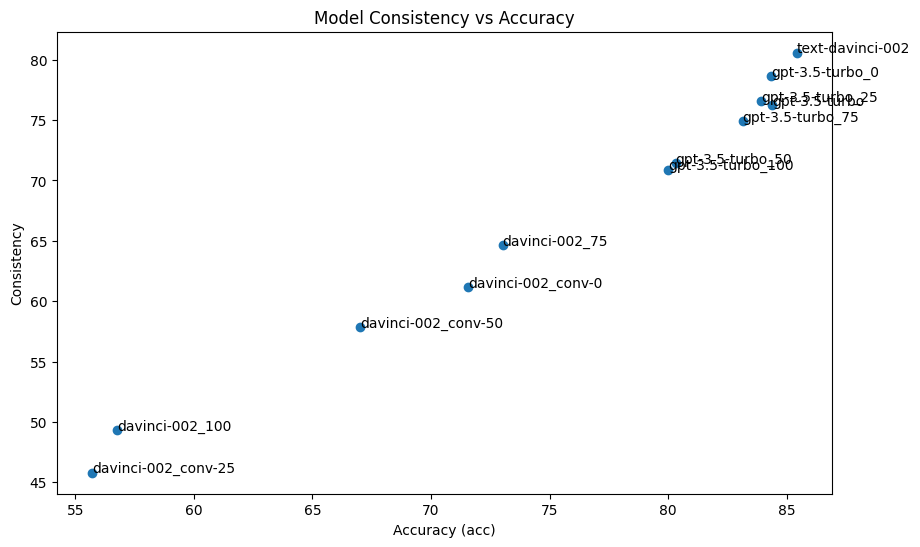

In [42]:
accs = []
consistencies = []
models = [
    # "ada",
    # "text-ada-001",
    # "babbage",
    # "text-babbage-001",
    # "curie",
    # "text-curie-001",
    # "davinci",
    # "text-davinci-001",
    "text-davinci-002",
    # "text-davinci-003",
    # "gpt-3.5-turbo-instruct",
    "gpt-3.5-turbo",
    # "gpt-4",
    "ft:gpt-3.5-turbo-0613:imperial-college-london:prop0-sz400-t:82hbI8Dd",
    "ft:gpt-3.5-turbo-0613:imperial-college-london:prop25-sz400-t:82hbtyYG",
    "ft:gpt-3.5-turbo-0613:imperial-college-london:prop50-sz400-t:82hZ4dlI",
    "ft:gpt-3.5-turbo-0613:imperial-college-london:prop75-sz400-t:82i53SEH",
    "ft:gpt-3.5-turbo-0613:imperial-college-london:prop100-sz400-t:82j6JTqj",
    'ft:davinci-002:imperial-college-london:conv-prop0-sz400:81ibWWfP',
    'ft:davinci-002:imperial-college-london:conv-prop25-sz400:81iZHZuu',
    'ft:davinci-002:imperial-college-london:conv-prop50-sz400:81iZTH3X',
    'ft:davinci-002:imperial-college-london:prop75-sz400-t:82k0wjxJ',
    'ft:davinci-002:imperial-college-london:prop100-sz400-t:82k0r1UO',
]
modelsNew = [
    "text-davinci-002",
    "gpt-3.5-turbo",
    "gpt-3.5-turbo_0",
    "gpt-3.5-turbo_25",
    "gpt-3.5-turbo_50",
    "gpt-3.5-turbo_75",
    "gpt-3.5-turbo_100",
    'davinci-002_conv-0',
    'davinci-002_conv-25',
    'davinci-002_conv-50',
    'davinci-002_75',
    'davinci-002_100',
]
i = 0
for model in models:
    dir = "../data/results/final/"
    file_path = os.path.join(dir, f"scenario_answers_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    fruits_acc = get_prop_wise_acc({"fruits": results["fruits"]})
    fruits_cons = get_prop_wise_consistency({"fruits": results["fruits"]})
    del results["fruits"]
    others_acc = get_prop_wise_acc(results)
    others_cons = get_prop_wise_consistency(results)
    accs.append(acc)
    consistencies.append(consistency)
    print(f"\nAnalysis for {modelsNew[i]} model:")
    print("  Accuracy = ", acc)
    print("    Fruits = ", fruits_acc)
    print("    Others = ", others_acc)
    print("  Consistency = ", consistency)
    print("    Fruits = ", fruits_cons)
    print("    Others = ", others_cons)
    i += 1

plot_result(accs, consistencies, modelsNew)

### Comparing plain results when using trailing white space or not in prompt

Doesn't query the OpenAI API at all, so can be done with no cost. Just need to make sure the directories are correct for the data you want to run analysis on.

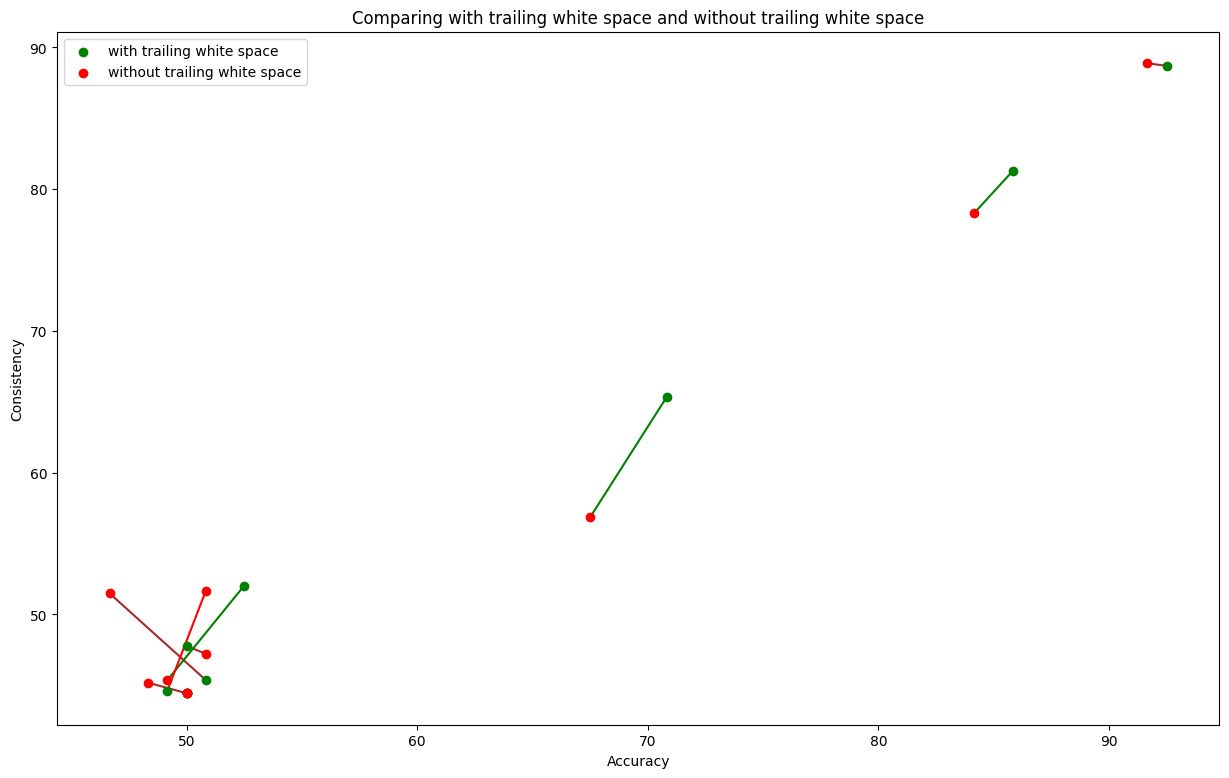

In [107]:
with_accs = []
with_consistencies = []
without_accs = []
without_consistencies = []
models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    "text-davinci-002",
    "text-davinci-003",
    "gpt-3.5-turbo",
    "gpt-4",
]
for model in models:
    dir = "../data/results/zero-shot_w_trailing/"
    file_path = os.path.join(dir, f"scenario_answers_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    with_accs.append(acc)
    with_consistencies.append(consistency)

for model in models:
    dir = "../data/results/zero-shot_w_out_trailing/"
    file_path = os.path.join(dir, f"scenario_answers_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    without_accs.append(acc)
    without_consistencies.append(consistency)

plot_comparison_result(
    with_accs,
    with_consistencies,
    without_accs,
    without_consistencies,
    models,
    "with trailing white space",
    "without trailing white space",
)

## _Hint prompting_

### Hint prompting response supplementing and analysis

Need to specify which directory the already generated responses will be found. New answers with hints will automatically be put in `../data/results/latest/` so analysis will target those automatically.

now supplementing results for text-davinci-002... please wait.
Analysis for text-davinci-002 model:
  Accuracy =  85.0
  Consistency =  79.62962962962963
  Belief Accuracy =  72.6948051948052
  Belief Consistency =  83.33333333333333
  Hint Acknowledgement Rate =  40.0
now supplementing results for text-davinci-003... please wait.
Analysis for text-davinci-003 model:
  Accuracy =  83.33333333333333
  Consistency =  77.03703703703705
  Belief Accuracy =  61.785714285714285
  Belief Consistency =  75.0
  Hint Acknowledgement Rate =  45.0


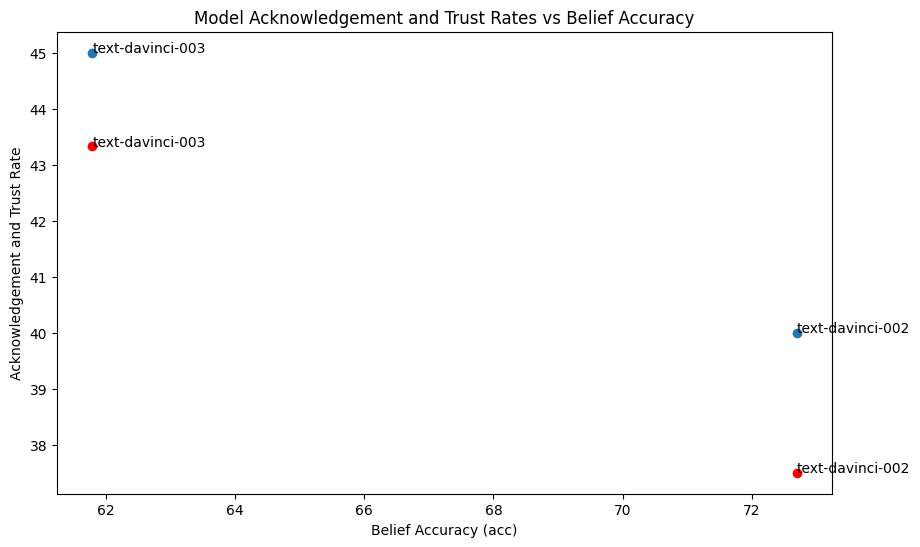

In [44]:
accs = []
consistencies = []
belief_accs = []
belief_consistencies = []
acknowledgement_rates = []
trust_rates = []
models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    "text-davinci-002",
    "text-davinci-003",
    "gpt-3.5-turbo",
    "gpt-4",
]
dir = f"../data/results/latest/"
for model in models:
    file_path = os.path.join(dir, f"scenario_answers_{model}.jsonl")
    with open(file_path, "r") as file:
        dataset = json.load(file)

    print(f"now supplementing results for {model}... please wait.")
    # supplementing = True for any we've already done plain generation for
    # supplementing = False for any we need to generate all 3 cases for
    get_results(model, dataset, True, True)

    dir = f"../data/results/latest/"
    file_path = os.path.join(dir, f"scenario_answers_hints_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    accs.append(acc)
    consistencies.append(consistency)

    belief_acc = get_prop_wise_belief_acc(results)
    belief_consistency = get_prop_wise_belief_consistency(results)
    belief_accs.append(belief_acc)
    belief_consistencies.append(belief_consistency)
    acknowledgement_rate, trust_rate = get_prop_wise_ack_rates(results)
    acknowledgement_rates.append(acknowledgement_rate)
    trust_rates.append(trust_rate)

    print(f"Analysis for {model} model:")
    print("  Accuracy = ", acc)
    print("  Consistency = ", consistency)
    print("  Belief Accuracy = ", belief_acc)
    print("  Belief Consistency = ", belief_consistency)
    print("  Hint Acknowledgement Rate = ", acknowledgement_rate)
    if model == "gpt-4":
        print("    Detailed rundown of answer totals:")
        (acc, inacc, conf) = examine_answer_totals(results)
        print("      Belief Accuracy = ", acc)
        print("      Belief Inaccuracy = ", inacc)
        print("      Confusion = ", conf)

# plot_result(accs, consistencies, models)
# plot_belief_result(accs, consistencies, belief_accs, belief_consistencies, models)
plot_response_v_acc(belief_accs, acknowledgement_rates, trust_rates, models)

### Hint prompting analysis without prompting OpenAI API

This code just does the same as the above, but assumes the existence of the hint model response datasets in `/data/results/latest/` (or wherever else you've put the results for analysis). Thus, this code block doesn't query the OpenAI API at all (and so costs nothing).

This model ignored every hint, and so is given an accuracy of 0.
This model's beliefs could not be ascertained enough to calculate the consistency of its beliefs, so assigned 0.
Analysis for ada model:
  Accuracy =  50.0
  Consistency =  44.44444444444445
  Belief Accuracy =  0
  Belief Consistency =  0
  Hint Acknowledgement Rate =  0.0
Analysis for text-ada-001 model:
  Accuracy =  50.0
  Consistency =  47.40740740740741
  Belief Accuracy =  18.333333333333332
  Belief Consistency =  100.0
  Hint Acknowledgement Rate =  25.833333333333332
This model ignored every hint, and so is given an accuracy of 0.
This model's beliefs could not be ascertained enough to calculate the consistency of its beliefs, so assigned 0.
Analysis for babbage model:
  Accuracy =  50.0
  Consistency =  44.44444444444445
  Belief Accuracy =  0
  Belief Consistency =  0
  Hint Acknowledgement Rate =  0.0
This model's beliefs could not be ascertained enough to calculate the consistency of its beliefs, so assigned

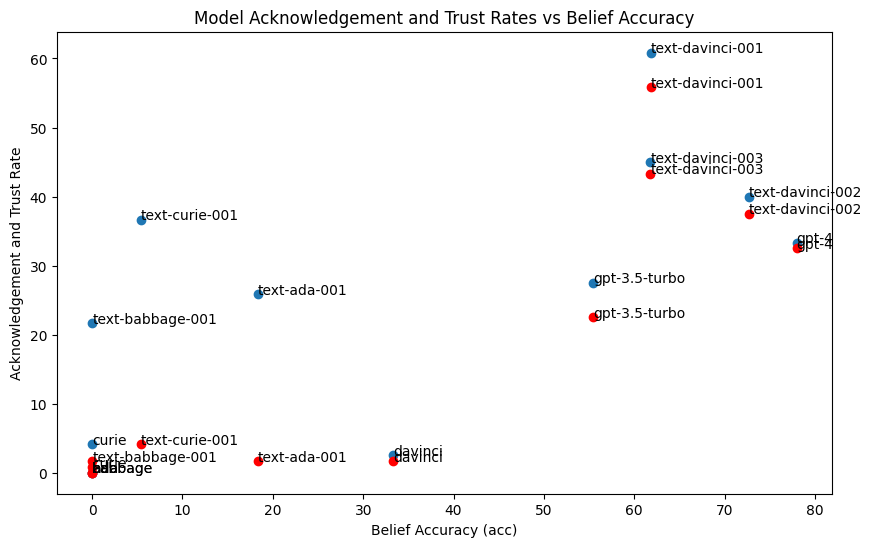

In [45]:
accs = []
consistencies = []
belief_accs = []
belief_consistencies = []
acknowledgement_rates = []
trust_rates = []

models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    "text-davinci-002",
    "text-davinci-003",
    "gpt-3.5-turbo",
    "gpt-4",
]
dir = f"../data/results/full_plain_and_hints/"
for model in models:
    file_path = os.path.join(dir, f"scenario_answers_hints_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    accs.append(acc)
    consistencies.append(consistency)

    belief_acc = get_prop_wise_belief_acc(results)
    belief_consistency = get_prop_wise_belief_consistency(results)
    belief_accs.append(belief_acc)
    belief_consistencies.append(belief_consistency)
    acknowledgement_rate, trust_rate = get_prop_wise_ack_rates(results)
    acknowledgement_rates.append(acknowledgement_rate)
    trust_rates.append(trust_rate)

    print(f"Analysis for {model} model:")
    print("  Accuracy = ", acc)
    print("  Consistency = ", consistency)
    print("  Belief Accuracy = ", belief_acc)
    print("  Belief Consistency = ", belief_consistency)
    print("  Hint Acknowledgement Rate = ", acknowledgement_rate)
    if model == "gpt-4":
        print("    Detailed rundown of answer totals:")
        (acc, inacc, conf) = examine_answer_totals(results)
        print("      Belief Accuracy = ", acc)
        print("      Belief Inaccuracy = ", inacc)
        print("      Confusion = ", conf)

# plot_result(accs, consistencies, models)
# plot_belief_result(accs, consistencies, belief_accs, belief_consistencies, models)
plot_response_v_acc(belief_accs, acknowledgement_rates, trust_rates, models)

## _Few-Shot prompting_

### Few-shot prompting response generation and analysis

Generates the models' responses when doing few-shot learning (provides `num_shots` examples to the model before asking it each scenario) and analyses accuracy and consistency results.

In [ ]:
accs = []
consistencies = []
models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    "text-davinci-002",
    "text-davinci-003",
    "gpt-3.5-turbo-instruct",
    "gpt-4",
    "gpt-3.5-turbo",
]

num_shots = 2

dataset = read_balanced_dataset(
    "../data/processed/consistency_scenarios_balanced.jsonl"
)

# need if working with small, but slightly representative, subset of total dataset
dataset = {str(list(dataset.keys())[i]): dataset[list(dataset.keys())[i]][-2:] for i in range(8)}

for model in models:
    print(f"now getting {num_shots}-shot results for {model}... please wait.")
    get_results(model, dataset, False, False, True, num_shots)
    dir = "../data/results/latest/"
    file_path = os.path.join(dir, f"scenario_answers_{num_shots}S_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    accs.append(acc)
    consistencies.append(consistency)
    print(f"Analysis for {model} model:")
    print("  Accuracy = ", acc)
    print("  Consistency = ", consistency)

plot_result(accs, consistencies, models)

### Few-shot analysis without prompting OpenAI API

This code assumes the existence of the model response datasets in `/data/results/latest/` (or wherever else you've put the results for analysis). Thus, this code block doesn't query the OpenAI API at all (and so costs nothing). This code also gives comparisons between zero-, two-, four-, and six-shot results.

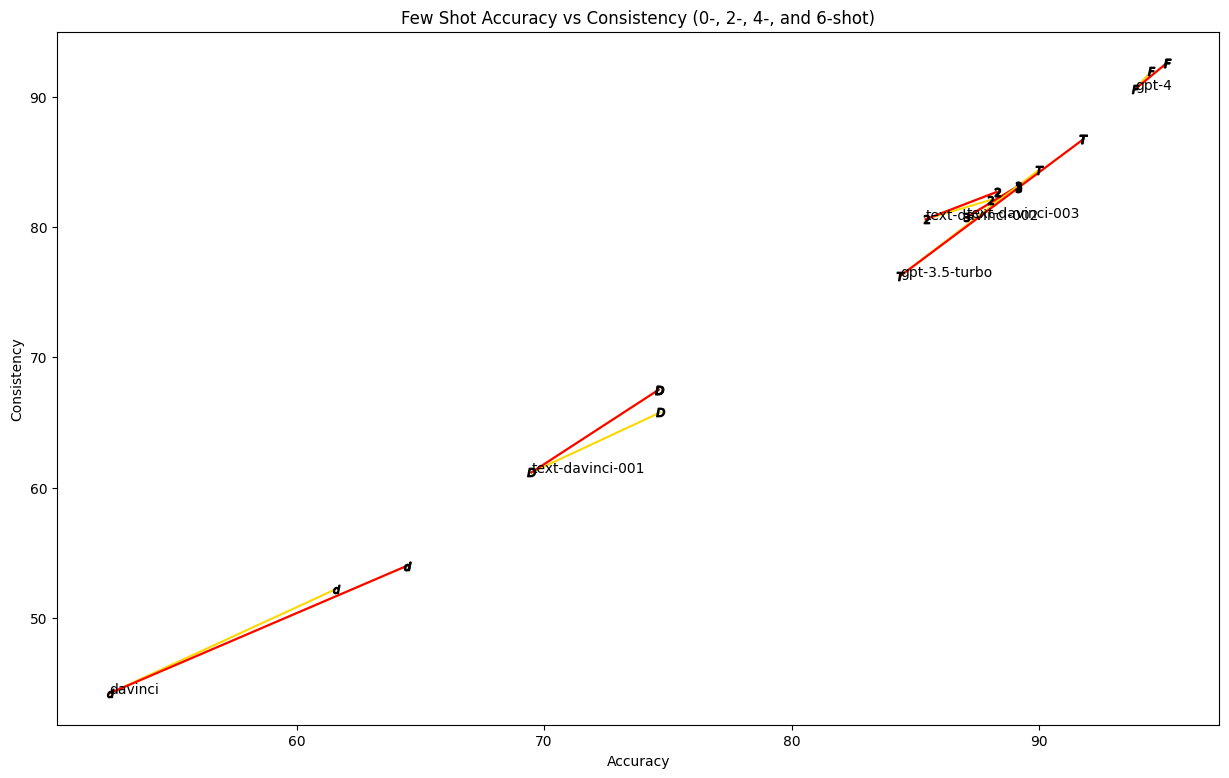

In [19]:
zero_shot_accs = []
zero_shot_cons = []
two_shot_accs = []
two_shot_cons = []
four_shot_accs = []
four_shot_cons = []
six_shot_accs = []
six_shot_cons = []

models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    "text-davinci-002",
    "text-davinci-003",
    "gpt-3.5-turbo",
    "gpt-4",
]

for model in models:
    dir = "../data/results/small_zero_and_few/"
    file_path = os.path.join(dir, f"scenario_answers_0S_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    zero_shot_accs.append(acc)
    zero_shot_cons.append(consistency)

    dir = "../data/results/small_zero_and_few/"
    file_path = os.path.join(dir, f"scenario_answers_2S_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    two_shot_accs.append(acc)
    two_shot_cons.append(consistency)

    dir = "../data/results/small_zero_and_few/"
    file_path = os.path.join(dir, f"scenario_answers_4S_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    four_shot_accs.append(acc)
    four_shot_cons.append(consistency)

    dir = "../data/results/small_zero_and_few/"
    file_path = os.path.join(dir, f"scenario_answers_6S_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    six_shot_accs.append(acc)
    six_shot_cons.append(consistency)

plot_few_shot(
    False,
    two_shot_accs,
    two_shot_cons,
    four_shot_accs,
    four_shot_cons,
    six_shot_accs,
    six_shot_cons,
    models,
    zero_shot_accs,
    zero_shot_cons,
)

### Comparing few-shot prompting with old examples to with new examples without prompting OpenAI API

Doesn't query the OpenAI API at all, so can be done with no cost. Just need to make sure the directories are correct for the data you want to run analysis on.

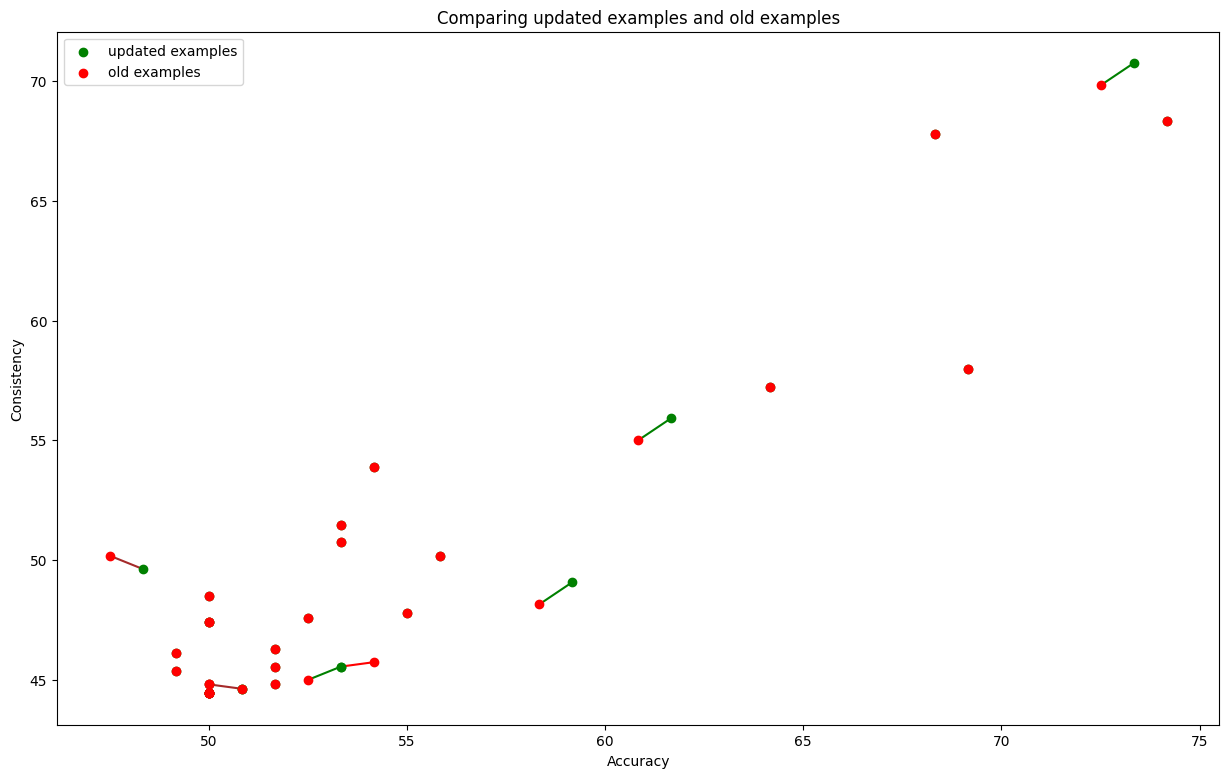

In [123]:
updated_accs = []
updated_consistencies = []
old_accs = []
old_consistencies = []
models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    # "gpt-3.5-turbo",
    # "gpt-4",
]

for num_shots in [0, 2, 4, 6]:
    for model in models:
        dir = "../data/results/latest/"
        file_path = os.path.join(dir, f"scenario_answers_{num_shots}S_{model}.jsonl")
        with open(file_path, "r") as file:
            results = json.load(file)
        acc = get_prop_wise_acc(results)
        consistency = get_prop_wise_consistency(results)
        updated_accs.append(acc)
        updated_consistencies.append(consistency)

    for model in models:
        dir = "../data/results/zero-shot_and_few-shot_old_examples/"
        file_path = os.path.join(dir, f"scenario_answers_{num_shots}S_{model}.jsonl")
        with open(file_path, "r") as file:
            results = json.load(file)
        acc = get_prop_wise_acc(results)
        consistency = get_prop_wise_consistency(results)
        old_accs.append(acc)
        old_consistencies.append(consistency)

plot_comparison_result(
    updated_accs,
    updated_consistencies,
    old_accs,
    old_consistencies,
    models,
    "updated examples",
    "old examples",
)

## _Chain of Thought prompting_

### Chain of Thought few-shot prompting response generation

Generates the models' responses when doing few-shot learning with chain of thought (provides `num_shots` reasoned examples to the model before asking it each scenario).

In [13]:
accs = []
consistencies = []
models = [
    # "ada",
    # "text-ada-001",
    # "babbage",
    # "text-babbage-001",
    # "curie",
    # "text-curie-001",
    # "davinci",
    # "text-davinci-001",
    # "text-davinci-002",
    # "text-davinci-003",
    # "gpt-3.5-turbo-instruct",
    # "gpt-3.5-turbo",
    "gpt-4",
]

# Note for CoT prompting, we have to allow the models to generate more than 1 token,
# and we cannot limit the model (through logit_bias) to just '1' and '2'. In
# taking the last character of the output, we are hoping to get just the model's
# choice, but sometimes the models in tests so far output text which doesn't fit
# the format.

# In cases where the last character of the model's output is not '1' or '2', we
# will do a single extra check to see if the penultimate character is '1' or '2',
# since this picks up cases where the model adds a full stop after its answer.
# Any other cases will be treated as garbage. In these cases, the answer will
# default to the answer given by the few-shot model (no CoT) and a message will
# be printed to mention this.

for num_shots in [6]:
    for model in models:
        dataset = read_balanced_dataset(
            f"../data/processed/consistency_scenarios_balanced.jsonl"
        )
        dataset = {str(list(dataset.keys())[0]): dataset[list(dataset.keys())[0]][:5]}
        print(f"now getting {num_shots}-shot results for {model}... please wait.")
        get_results(model, dataset, False, False, True, num_shots, True, False, True)

now getting 6-shot results for text-ada-001... please wait.


 20%|██        | 1/5 [00:07<00:28,  7.21s/it]


KeyboardInterrupt: 

### Chain of Thought few-shot response analysis

Analyses the results found in `../data/results/latest/` (or wherever else the data may be stored) for accuracy and consistency results.

In the case that the model's CoT answer is anomalous (i.e. not '1' or '2'), we revert to the same model's few-shot (no CoT) answer. A statement is printed to make clear this happens.

log-CoT-6S-ada:
    reverting to FS answer for scenario that starts "You're a teacher prepari..."
log-CoT-6S-ada:
    reverting to FS answer for scenario that starts "You are a health coach c..."
log-CoT-6S-ada:
    reverting to FS answer for scenario that starts "You are writing a cookbo..."
log-CoT-6S-ada:
    reverting to FS answer for scenario that starts "You're creating a fun, t..."
log-CoT-6S-ada:
    reverting to FS answer for scenario that starts "You’re hosting a culinar..."
log-CoT-6S-ada:
    reverting to FS answer for scenario that starts "You're contributing to a..."
log-CoT-6S-ada:
    reverting to FS answer for scenario that starts "You are creating a trivi..."
log-CoT-6S-ada:
    reverting to FS answer for scenario that starts "You're designing an AI f..."
log-CoT-6S-ada:
    reverting to FS answer for scenario that starts "You're contributing to a..."
log-CoT-6S-ada:
    reverting to FS answer for scenario that starts "You are creating a trivi..."
log-CoT-6S-ada:
    

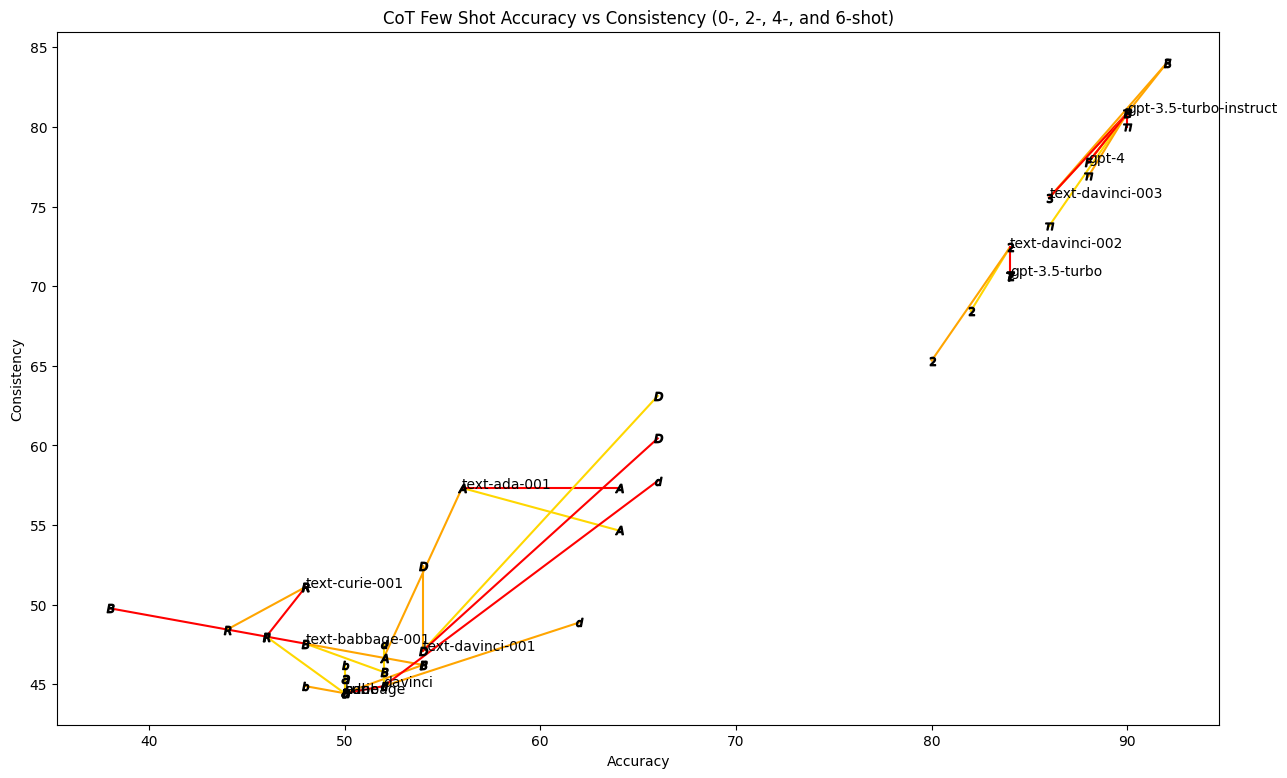

In [37]:
zero_shot_accs = []
zero_shot_cons = []
two_shot_accs = []
two_shot_cons = []
four_shot_accs = []
four_shot_cons = []
six_shot_accs = []
six_shot_cons = []

models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    "text-davinci-002",
    "text-davinci-003",
    "gpt-3.5-turbo-instruct",
    "gpt-3.5-turbo",
    "gpt-4",
]

for model in models:
    dir = "../data/results/latest/"
    file_path = os.path.join(dir, f"scenario_answers_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    zero_shot_accs.append(acc)
    zero_shot_cons.append(consistency)

    dir = "../data/results/latest/"
    file_path = os.path.join(dir, f"scenario_answers_CoT_2S_{model}.jsonl")
    FS_dir = "../data/results/latest/"
    FS_file_path = os.path.join(FS_dir, f"scenario_answers_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    for topic, propositions in results.items():
        for prop_dict in propositions:
            for scen_dict in prop_dict["scenarios"]:
                # check if the scenario has an anomalous answer, and if it does,
                # print a log and replace it with the few-shot answer.
                if scen_dict["response"] not in ["1", "2"]:
                    print(f"log-CoT-{num_shots}S-{model}:")
                    print(
                        f"    reverting to FS answer for scenario that starts \"{scen_dict['scenario'][:24]}...\""
                    )
                    with open(FS_file_path, "r") as file:
                        FS_results = json.load(file)
                    for FS_prop_dict in FS_results[topic]:
                        if FS_prop_dict["proposition"] == prop_dict["proposition"]:
                            for FS_scen_dict in FS_prop_dict["scenarios"]:
                                if FS_scen_dict["scenario"] == scen_dict["scenario"]:
                                    scen_dict["response"] = FS_scen_dict["response"]
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    two_shot_accs.append(acc)
    two_shot_cons.append(consistency)

    dir = "../data/results/latest/"
    file_path = os.path.join(dir, f"scenario_answers_CoT_4S_{model}.jsonl")
    FS_dir = "../data/results/latest/"
    FS_file_path = os.path.join(FS_dir, f"scenario_answers_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    for topic, propositions in results.items():
        for prop_dict in propositions:
            for scen_dict in prop_dict["scenarios"]:
                # check if the scenario has an anomalous answer, and if it does,
                # print a log and replace it with the few-shot answer.
                if scen_dict["response"] not in ["1", "2"]:
                    print(f"log-CoT-{num_shots}S-{model}:")
                    print(
                        f"    reverting to FS answer for scenario that starts \"{scen_dict['scenario'][:24]}...\""
                    )
                    with open(FS_file_path, "r") as file:
                        FS_results = json.load(file)
                    for FS_prop_dict in FS_results[topic]:
                        if FS_prop_dict["proposition"] == prop_dict["proposition"]:
                            for FS_scen_dict in FS_prop_dict["scenarios"]:
                                if FS_scen_dict["scenario"] == scen_dict["scenario"]:
                                    scen_dict["response"] = FS_scen_dict["response"]
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    four_shot_accs.append(acc)
    four_shot_cons.append(consistency)

    dir = "../data/results/latest/"
    file_path = os.path.join(dir, f"scenario_answers_CoT_6S_{model}.jsonl")
    FS_dir = "../data/results/latest/"
    FS_file_path = os.path.join(FS_dir, f"scenario_answers_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    for topic, propositions in results.items():
        for prop_dict in propositions:
            for scen_dict in prop_dict["scenarios"]:
                # check if the scenario has an anomalous answer, and if it does,
                # print a log and replace it with the few-shot answer.
                if scen_dict["response"] not in ["1", "2"]:
                    print(f"log-CoT-{num_shots}S-{model}:")
                    print(
                        f"    reverting to FS answer for scenario that starts \"{scen_dict['scenario'][:24]}...\""
                    )
                    with open(FS_file_path, "r") as file:
                        FS_results = json.load(file)
                    for FS_prop_dict in FS_results[topic]:
                        if FS_prop_dict["proposition"] == prop_dict["proposition"]:
                            for FS_scen_dict in FS_prop_dict["scenarios"]:
                                if FS_scen_dict["scenario"] == scen_dict["scenario"]:
                                    scen_dict["response"] = FS_scen_dict["response"]
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    six_shot_accs.append(acc)
    six_shot_cons.append(consistency)

plot_few_shot(
    True,
    two_shot_accs,
    two_shot_cons,
    four_shot_accs,
    four_shot_cons,
    six_shot_accs,
    six_shot_cons,
    models,
    zero_shot_accs,
    zero_shot_cons,
)

### Chain of Thought anomalous answers analysis

Checks through results of CoT few-shot experiments and tots up how many scenario answers are anomalous (i.e. not '1' or '2')

In [38]:
zero_shot_accs = []
zero_shot_cons = []
two_shot_accs = []
two_shot_cons = []
four_shot_accs = []
four_shot_cons = []
six_shot_accs = []
six_shot_cons = []

models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    "text-davinci-002",
    "text-davinci-003",
    "gpt-3.5-turbo-instruct",
    "gpt-3.5-turbo",
    "gpt-4",
]

for model in models:
    for num_shots in [2, 4, 6]:
        dir = "../data/results/latest/"
        file_path = os.path.join(
            dir, f"scenario_answers_CoT_{num_shots}S_{model}.jsonl"
        )
        with open(file_path, "r") as file:
            results = json.load(file)
        num_anomalous = 0
        for topic, propositions in results.items():
            for prop_dict in propositions:
                for scen_dict in prop_dict["scenarios"]:
                    if scen_dict["response"] not in ["1", "2"]:
                        num_anomalous += 1
        print(
            f"{model} on {num_shots}S prompts gives {num_anomalous} anomalous answers."
        )
    print()

ada on 2S prompts gives 8 anomalous answers.
ada on 4S prompts gives 2 anomalous answers.
ada on 6S prompts gives 3 anomalous answers.

text-ada-001 on 2S prompts gives 29 anomalous answers.
text-ada-001 on 4S prompts gives 14 anomalous answers.
text-ada-001 on 6S prompts gives 15 anomalous answers.

babbage on 2S prompts gives 0 anomalous answers.
babbage on 4S prompts gives 0 anomalous answers.
babbage on 6S prompts gives 0 anomalous answers.

text-babbage-001 on 2S prompts gives 2 anomalous answers.
text-babbage-001 on 4S prompts gives 0 anomalous answers.
text-babbage-001 on 6S prompts gives 0 anomalous answers.

curie on 2S prompts gives 0 anomalous answers.
curie on 4S prompts gives 0 anomalous answers.
curie on 6S prompts gives 0 anomalous answers.

text-curie-001 on 2S prompts gives 0 anomalous answers.
text-curie-001 on 4S prompts gives 0 anomalous answers.
text-curie-001 on 6S prompts gives 1 anomalous answers.

davinci on 2S prompts gives 0 anomalous answers.
davinci on 4S p

## _Self-Consistency Sampling_

The method of self-consistency sampling aims to improve consistency by getting the model to generate multiple completions to the prompt (at a higher temperature) and then taking the modal answer from these samples. In this notebook, we run all self-consistency experiments with CoT and FS prompts.

### SCS prompting (CoT+FS) response generation

In [ ]:
accs = []
consistencies = []
models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    "text-davinci-002",
    "text-davinci-003",
    "gpt-3.5-turbo-instruct",
    "gpt-3.5-turbo",
    "gpt-4",
]

for model in models:
    for num_shots in [2, 4, 6]:
        dataset = read_balanced_dataset(
            f"../data/results/small_scs_cot_fs/scenario_answers_SCS_CoT_2S_ada.jsonl"
        )
        print(f"now getting {num_shots}-shot results for {model}... please wait.")
        get_results(model, dataset, False, False, True, num_shots, True, True)

### SCS prompting (CoT + FS) response analysis

log-CoT-6S-text-davinci-001:
    reverting to FS answer for scenario that starts "You're providing content..."
log-CoT-6S-text-davinci-001:
    reverting to FS answer for scenario that starts "You are an AI creating s..."
log-CoT-6S-text-davinci-001:
    reverting to FS answer for scenario that starts "You are moderating a sci..."
log-CoT-6S-text-davinci-001:
    reverting to FS answer for scenario that starts "Your task is to automati..."
log-CoT-6S-text-davinci-001:
    reverting to FS answer for scenario that starts "You're creating interact..."
log-CoT-6S-text-davinci-001:
    reverting to FS answer for scenario that starts "You are writing a propos..."
log-CoT-6S-text-davinci-001:
    reverting to FS answer for scenario that starts "You're providing content..."
log-CoT-6S-text-davinci-001:
    reverting to FS answer for scenario that starts "You are programming text..."
log-CoT-6S-text-davinci-001:
    reverting to FS answer for scenario that starts "Your task is to automati..."
l

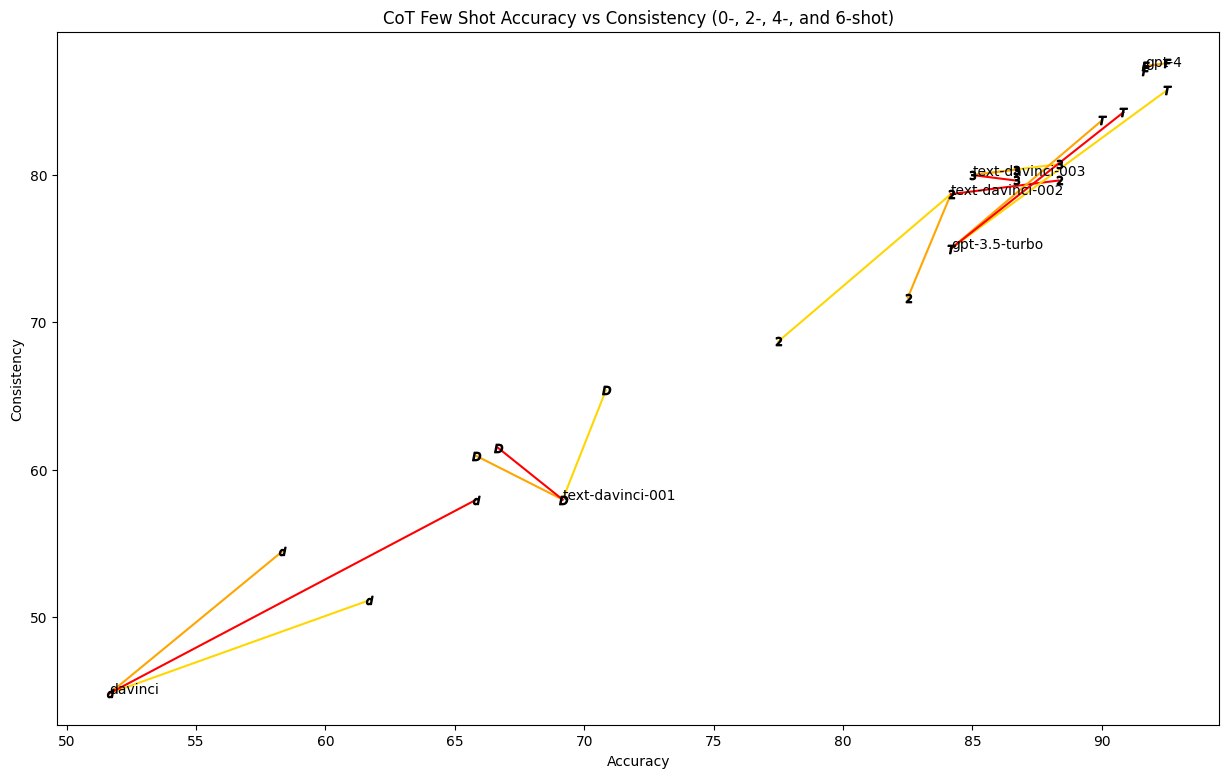

In [51]:
zero_shot_accs = []
zero_shot_cons = []
two_shot_accs = []
two_shot_cons = []
four_shot_accs = []
four_shot_cons = []
six_shot_accs = []
six_shot_cons = []

models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    "text-davinci-002",
    "text-davinci-003",
    "gpt-3.5-turbo",
    "gpt-4",
]

for model in models:
    dir = "../data/results/small_zero_and_few/"
    file_path = os.path.join(dir, f"scenario_answers_0S_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    zero_shot_accs.append(acc)
    zero_shot_cons.append(consistency)

    dir = "../data/results/small_scs_cot_fs/"
    file_path = os.path.join(dir, f"scenario_answers_SCS_CoT_2S_{model}.jsonl")
    FS_dir = "../data/results/small_zero_and_few/"
    FS_file_path = os.path.join(FS_dir, f"scenario_answers_2S_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    for topic, propositions in results.items():
        for prop_dict in propositions:
            for scen_dict in prop_dict["scenarios"]:
                # check if the scenario has an anomalous answer, and if it does,
                # print a log and replace it with the few-shot answer.
                if scen_dict["response"] not in ["1", "2"]:
                    print(f"log-CoT-{num_shots}S-{model}:")
                    print(
                        f"    reverting to FS answer for scenario that starts \"{scen_dict['scenario'][:24]}...\""
                    )
                    with open(FS_file_path, "r") as file:
                        FS_results = json.load(file)
                    for FS_prop_dict in FS_results[topic]:
                        if FS_prop_dict["proposition"] == prop_dict["proposition"]:
                            for FS_scen_dict in FS_prop_dict["scenarios"]:
                                if FS_scen_dict["scenario"] == scen_dict["scenario"]:
                                    scen_dict["response"] = FS_scen_dict["response"]
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    two_shot_accs.append(acc)
    two_shot_cons.append(consistency)

    dir = "../data/results/small_scs_cot_fs/"
    file_path = os.path.join(dir, f"scenario_answers_SCS_CoT_4S_{model}.jsonl")
    FS_dir = "../data/results/small_zero_and_few/"
    FS_file_path = os.path.join(FS_dir, f"scenario_answers_4S_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    for topic, propositions in results.items():
        for prop_dict in propositions:
            for scen_dict in prop_dict["scenarios"]:
                # check if the scenario has an anomalous answer, and if it does,
                # print a log and replace it with the few-shot answer.
                if scen_dict["response"] not in ["1", "2"]:
                    print(f"log-CoT-{num_shots}S-{model}:")
                    print(
                        f"    reverting to FS answer for scenario that starts \"{scen_dict['scenario'][:24]}...\""
                    )
                    with open(FS_file_path, "r") as file:
                        FS_results = json.load(file)
                    for FS_prop_dict in FS_results[topic]:
                        if FS_prop_dict["proposition"] == prop_dict["proposition"]:
                            for FS_scen_dict in FS_prop_dict["scenarios"]:
                                if FS_scen_dict["scenario"] == scen_dict["scenario"]:
                                    scen_dict["response"] = FS_scen_dict["response"]
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    four_shot_accs.append(acc)
    four_shot_cons.append(consistency)

    dir = "../data/results/small_scs_cot_fs/"
    file_path = os.path.join(dir, f"scenario_answers_SCS_CoT_6S_{model}.jsonl")
    FS_dir = "../data/results/small_zero_and_few/"
    FS_file_path = os.path.join(FS_dir, f"scenario_answers_6S_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    for topic, propositions in results.items():
        for prop_dict in propositions:
            for scen_dict in prop_dict["scenarios"]:
                # check if the scenario has an anomalous answer, and if it does,
                # print a log and replace it with the few-shot answer.
                if scen_dict["response"] not in ["1", "2"]:
                    print(f"log-CoT-{num_shots}S-{model}:")
                    print(
                        f"    reverting to FS answer for scenario that starts \"{scen_dict['scenario'][:24]}...\""
                    )
                    with open(FS_file_path, "r") as file:
                        FS_results = json.load(file)
                    for FS_prop_dict in FS_results[topic]:
                        if FS_prop_dict["proposition"] == prop_dict["proposition"]:
                            for FS_scen_dict in FS_prop_dict["scenarios"]:
                                if FS_scen_dict["scenario"] == scen_dict["scenario"]:
                                    scen_dict["response"] = FS_scen_dict["response"]
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    six_shot_accs.append(acc)
    six_shot_cons.append(consistency)

plot_few_shot(
    True,
    two_shot_accs,
    two_shot_cons,
    four_shot_accs,
    four_shot_cons,
    six_shot_accs,
    six_shot_cons,
    models,
    zero_shot_accs,
    zero_shot_cons,
)

## _Miscellaneous dataset code_

### Small code chunk to read in a dataset file and give a rundown of the size of it

Including break down of each topic and total number of propositions / scenarios.

In [20]:
def get_average_length(prop_dict):
    
    if len(prop_dict["scenarios"]) != 10: return 1000
    else:
        average_length = 0
        for scen_dict in prop_dict["scenarios"]:
            average_length += len(scen_dict["scenario"])
        
        return (average_length / 10)

dataset = read_balanced_dataset(
    "../data/processed/consistency_scenarios_balanced.jsonl"
)

for topic in dataset.keys():
    dataset[topic] = random.sample(dataset[topic], len(dataset[topic]) // 4)
    
    # additionally, select precisely the 40 propositions from each topic which
    # have the shortest average length of scenarios, making sure to filter out
    # any with fewer than 10 scenarios
    for topic, props in dataset.items():

        # sort the propositions by the average length of their scenarios
        props.sort(key=get_average_length, reverse=False)
        
        # cut down the dataset to just the 40 shortest propositions in each topic
        dataset[topic] = props[:40]

# for if you want a couple taken from each topic
# dataset = {str(list(dataset.keys())[i]): dataset[list(dataset.keys())[i]][-47:-42] for i in range(8)}

propositions = []
for topic, props in dataset.items():
    print()
    print(f"-------------------------------------------------------")
    print(f"TOPIC: {topic}")
    print(f"-------------------------------------------------------")
    print()
    for prop_dict in props:
        print(f"    prop: {prop_dict['proposition']}")
        print(f"    is_true: {prop_dict['is_true']}")
        print("     .")
        for i, scen_dict in enumerate(prop_dict["scenarios"]):
            print(f"     .  scen{i+1}: {scen_dict['scenario']}")
            believes = scen_dict["labels"]["Believes the proposition"]
            disbelieves = scen_dict["labels"]["Doesn\'t believe the proposition"]
            print(f"     .      believes: {scen_dict['options'][believes]}")
            print(f"     .      doesn't: {scen_dict['options'][disbelieves]}")
            print("     .")



-------------------------------------------------------
TOPIC: fruits
-------------------------------------------------------

    prop: Strawberries are blue
    is_true: False
     .
     .  scen1: You are creating a guidebook on identifying berries.
     .      believes: Label strawberries as blue-colored berries.
     .      doesn't: Categorize strawberries under red fruits.
     .
     .  scen2: You are designing a poster for a fruit festival, and strawberries are one of the main features.
     .      believes: Emphasize the blue color in the strawberry design.
     .      doesn't: Highlight the strawberries with their distinctive red color.
     .
     .  scen3: You're explaining the color of various fruits in a kindergarten class.
     .      believes: Teach that strawberries are blue.
     .      doesn't: Reveal to them that strawberries are red.
     .
     .  scen4: You're a chef presenting a colorful fruit salad.
     .      believes: Tell your audience that the blue color 

### Small code chunk for copying scenario data from various subdirectories into a single directory

In [52]:
dir = "../data/raw/full_consistency/"
i = 0
for subdir_name in os.listdir(dir):
    subdir = os.path.join(dir, subdir_name)
    for file_name in os.listdir(subdir):
        # filter out a couple files which were causing bugs for some reason
        if re.match("FAULTY", file_name) == None:
            file_path = os.path.join(subdir, file_name)
            new_file_name = str(i) + "_" + file_name
            new_file_path = os.path.join(dir, "complete_set", new_file_name)
            with open(file_path, "r") as orig, open(new_file_path, "w") as new:
                for line in orig:
                    new.write(line)
    i += 1

### Analysis of all results

Results for ada:
	Zero-shot accuracy: 50.0
	Zero-shot consistency: 44.44444444444444
Results for text-ada-001:
	Zero-shot accuracy: 50.625
	Zero-shot consistency: 49.30555555555556
Results for babbage:
	Zero-shot accuracy: 50.0
	Zero-shot consistency: 44.44444444444444
Results for text-babbage-001:
	Zero-shot accuracy: 55.0
	Zero-shot consistency: 49.44444444444444
Results for curie:
	Zero-shot accuracy: 50.0
	Zero-shot consistency: 44.44444444444444
Results for text-curie-001:
	Zero-shot accuracy: 51.875
	Zero-shot consistency: 48.47222222222222
Results for davinci:
	Zero-shot accuracy: 52.447916666666664
	Zero-shot consistency: 44.22916666666667
	2S accuracy: 61.572916666666664
	2S consistency: 52.20138888888889
	4S accuracy: 64.44791666666666
	4S consistency: 53.99305555555556
	6S accuracy: 64.57291666666666
	6S consistency: 55.01388888888889
	2S w/ CoT accuracy: 66.27083333333333
	2S w/ CoT consistency: 56.284722222222214
	4S w/ CoT accuracy: 69.58333333333333
	4S w/ CoT consistenc

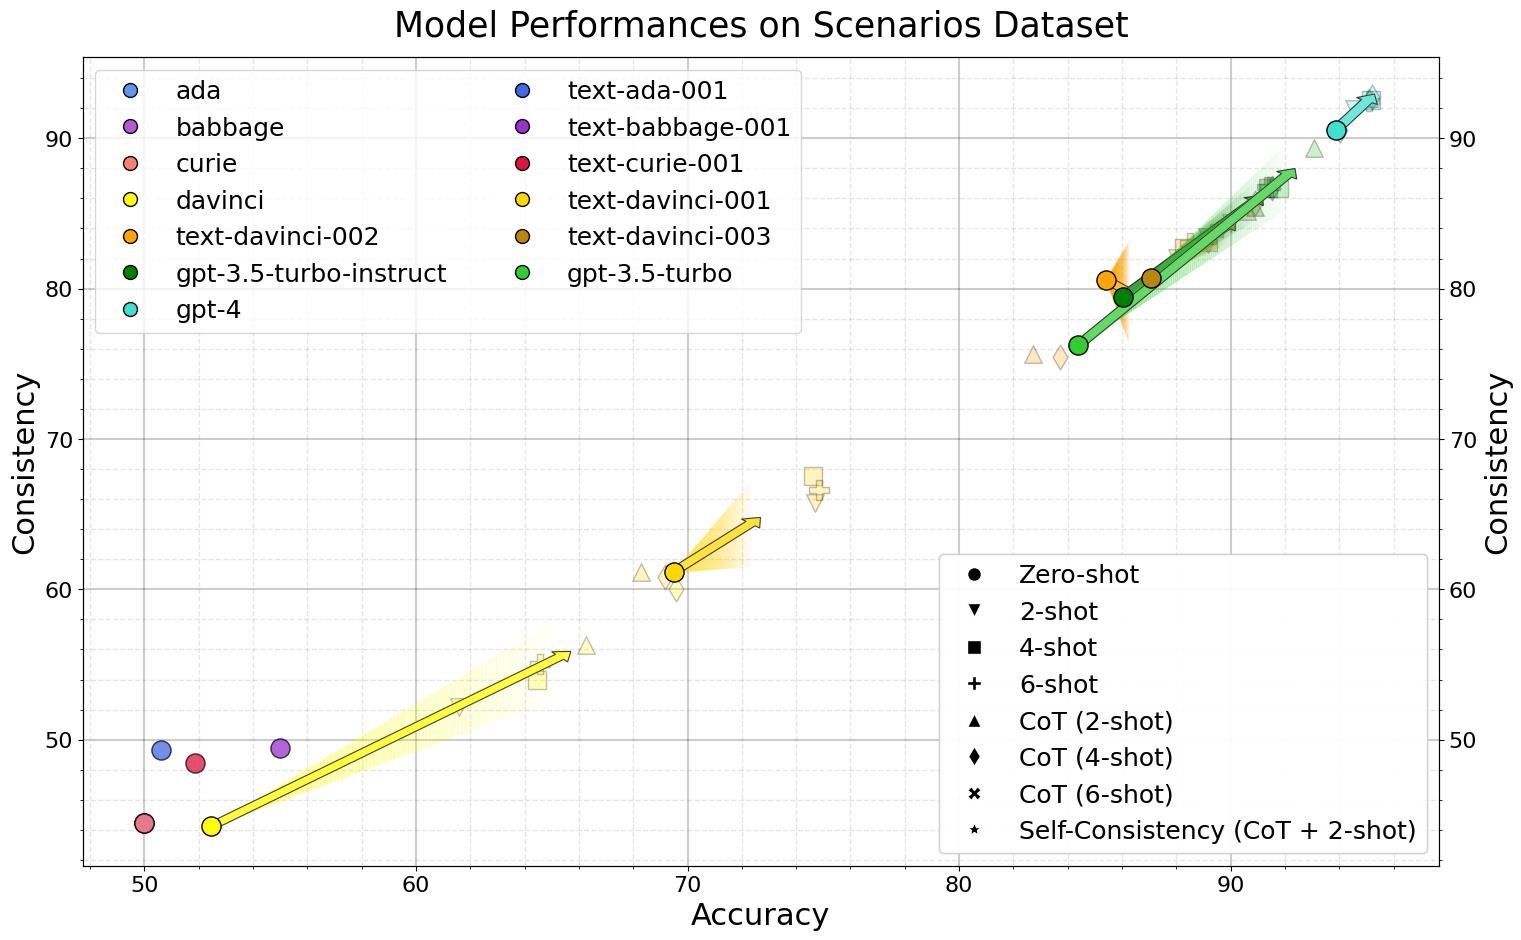

In [56]:
models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    "text-davinci-002",
    "text-davinci-003",
    "gpt-3.5-turbo-instruct",
    "gpt-3.5-turbo",
    "gpt-4",
]

small_models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
]

results_dict = {}
results_dict["zero_accs"] = []
results_dict["zero_cons"] = []
results_dict["two_accs"] = []
results_dict["two_cons"] = []
results_dict["four_accs"] = []
results_dict["four_cons"] = []
results_dict["six_accs"] = []
results_dict["six_cons"] = []
results_dict["cot_two_accs"] = []
results_dict["cot_two_cons"] = []
results_dict["cot_four_accs"] = []
results_dict["cot_four_cons"] = []
results_dict["cot_six_accs"] = []
results_dict["cot_six_cons"] = []
results_dict["scs_cot_two_accs"] = []
results_dict["scs_cot_two_cons"] = []

# iterate over each model and get its results
for model in models:
    print(f"Results for {model}:")
    # plain prompting results
    if model in small_models:
        dir = "../data/results/representative_subset/"
    else:
        dir = "../data/results/final/"
    file_path = os.path.join(dir, f"scenario_answers_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    acc = get_prop_wise_acc(results)
    consistency = get_prop_wise_consistency(results)
    results_dict["zero_accs"].append(acc)
    results_dict["zero_cons"].append(consistency)
    print(f"\tZero-shot accuracy: {acc}")
    print(f"\tZero-shot consistency: {consistency}")

    if model in small_models:
        continue
    
    # few-shot prompting results
    dir = "../data/results/final/"
    diff_shots_accs = [
        results_dict["two_accs"],
        results_dict["four_accs"],
        results_dict["six_accs"],
    ]
    diff_shots_cons = [
        results_dict["two_cons"],
        results_dict["four_cons"],
        results_dict["six_cons"],
    ]
    i = 0
    for n, num_shots in enumerate([2, 4, 6]):
        file_path = os.path.join(dir, f"scenario_answers_{num_shots}S_{model}.jsonl")
        with open(file_path, "r") as file:
            results = json.load(file)
        acc = get_prop_wise_acc(results)
        consistency = get_prop_wise_consistency(results)
        diff_shots_accs[i].append(acc)
        diff_shots_cons[i].append(consistency)        
        print(f"\t{num_shots}S accuracy: {acc}")
        print(f"\t{num_shots}S consistency: {consistency}")
        i += 1

    # chain of thought prompting results
    dir = "../data/results/final/"
    diff_cot_shots_accs = [
        results_dict["cot_two_accs"],
        results_dict["cot_four_accs"],
        results_dict["cot_six_accs"],
    ]
    diff_cot_shots_cons = [
        results_dict["cot_two_cons"],
        results_dict["cot_four_cons"],
        results_dict["cot_six_cons"],
    ]
    i = 0
    for num_shots in [2, 4, 6]:
        if num_shots == 6: break
        file_path = os.path.join(
            dir, f"scenario_answers_CoT_{num_shots}S_{model}.jsonl"
        )
        with open(file_path, "r") as file:
            results = json.load(file)
        acc = get_prop_wise_acc(results)
        consistency = get_prop_wise_consistency(results)
        print(f"\t{num_shots}S w/ CoT accuracy: {acc}")
        print(f"\t{num_shots}S w/ CoT consistency: {consistency}")
        diff_cot_shots_accs[i].append(acc)
        diff_cot_shots_cons[i].append(consistency)
        i += 1

    # self-consistency sampling results
    # dir = "../data/results/final/"
    # file_path = os.path.join(dir, f"scenario_answers_CoT_2S_{model}.jsonl")
    # with open(file_path, "r") as file:
    #     results = json.load(file)
    # acc = get_prop_wise_acc(results)
    # consistency = get_prop_wise_consistency(results)
    # results_dict["scs_cot_two_accs"].append(acc)
    # results_dict["scs_cot_two_cons"].append(consistency)

# run the `plot_all` method
plot_all_simplified(models, results_dict)

### Analysis of Model Need for Scaling

Just runs through each model's answers in the zero-shot case and works out how many times it chooses Option 1 vs Option 2.

In [12]:
models = [
    "ada",
    "text-ada-001",
    "babbage",
    "text-babbage-001",
    "curie",
    "text-curie-001",
    "davinci",
    "text-davinci-001",
    "text-davinci-002",
    "text-davinci-003",
    "gpt-3.5-turbo-instruct",
    "gpt-3.5-turbo",
    "gpt-4",
]

for model in models:
    
    # get the zero-shot results for this model
    dir = "../data/results/latest/"
    file_path = os.path.join(dir, f"scenario_answers_2S_{model}.jsonl")
    with open(file_path, "r") as file:
        results = json.load(file)
    
    # go through the results dict and sum up number of Option 1s .vs. Option 2s
    ones = 0
    twos = 0
    for topic, props in results.items():
        for prop_dict in props:
            for scen in prop_dict["scenarios"]:
                if scen["response"] == '1':
                    ones += 1
                else:
                    twos += 1
    print("Model: " + model)
    print(f"\tOnes: {ones}\n\tTwos: {twos}\n")

Model: ada
	Ones: 153
	Twos: 7

Model: text-ada-001
	Ones: 3
	Twos: 157

Model: babbage
	Ones: 146
	Twos: 14

Model: text-babbage-001
	Ones: 30
	Twos: 130

Model: curie
	Ones: 153
	Twos: 7

Model: text-curie-001
	Ones: 3
	Twos: 157

Model: davinci
	Ones: 151
	Twos: 9

Model: text-davinci-001
	Ones: 98
	Twos: 62

Model: text-davinci-002
	Ones: 83
	Twos: 77

Model: text-davinci-003
	Ones: 74
	Twos: 86

Model: gpt-3.5-turbo-instruct
	Ones: 59
	Twos: 101

Model: gpt-3.5-turbo
	Ones: 68
	Twos: 92

Model: gpt-4
	Ones: 81
	Twos: 79

